In [ ]:
from google.colab import drive
drive.mount("/content/drive")
%cd /content/drive/MyDrive/Capstone_Accenture4/deprecated modeling files/Data/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Capstone_Accenture4/deprecated modeling files/Data


#### Dependencies

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from time import time

import tensorflow as tf
import tensorflow.keras.backend as K

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import *
from tensorflow.keras import layers
from tensorflow.keras.callbacks import History, EarlyStopping
from tensorflow import keras

### Global

In [ ]:
dic_country = \
{'AUS': 'Australia',
 'BRA': 'Brazil',
 'CAN': 'India',
 'CHN': 'China',
 'GBR': 'United Kingdom',
 'IND': 'India',
 'JPN': 'Japan',
 'SGP': 'Singapore',
 'USA': 'United States'}
pd.DataFrame(dic_country,index=[0]).T.reset_index().rename(columns = {'index': 'country_code', 0: 'country_name'})

country_code    country_name
0          AUS       Australia
1          BRA          Brazil
2          CAN           India
3          CHN           China
4          GBR  United Kingdom
5          IND           India
6          JPN           Japan
7          SGP       Singapore
8          USA   United States

### Data

Use (country_code, imputation_method) to store corresponding df
- m_dfs: manufacturing data
- s_dfs: service data

In [ ]:
Data_dic_m = pd.ExcelFile('Manufacturing_1_filled.xlsx')
Data_dic_s = pd.ExcelFile('Service_1_filled.xlsx')

In [ ]:
def get_sheet_by_methods(data, method_num, verbose = 0):
  sheet_names = data.sheet_names
  sheet_imputation_map = pd.DataFrame([[s, s[:3].strip(),s[3:]] for s in sheet_names], columns = ['sheet_name', 'country_code', 'imputation method'])
  methods = sheet_imputation_map['imputation method'].unique()
  if verbose:
    print('methods tried:',methods, len(methods))
  return list(sheet_imputation_map.loc[sheet_imputation_map['imputation method'] == methods[method_num]]['sheet_name'].values)

In [ ]:
m_dfs = {}
for i in range(len(Data_dic_m.sheet_names) // 10):
  for sheet in get_sheet_by_methods(Data_dic_m, i):
    df = pd.read_excel(Data_dic_m, sheet_name=sheet)
    df['Year'] = [i.year for i in pd.to_datetime(df.Year, format='%Y')]
    df = df.set_index('Year')
    m_dfs[(sheet[:3], sheet[3:].strip())] = df

### Scaling

In [ ]:
class MRobustScaler():
      """
      Scale features using statistics that are robust to outliers.
      """
      def __init__(self, q1=0.2, q2=0.8):
          self.q1 = q1
          self.q2 = q2

      def fit(self, df, eps):
          """
          Return quantile range and median of all features

          Set qrange be 1 if feature has very small range, otherwise calculate
          the quantile range with specified quantile
          """
          df = df.astype('float64') # convert object to float
          self.df_median = df.median() #pd median uses np.nanmedian
          df_q1 = df.quantile(self.q1)
          df_q2 = df.quantile(self.q2)
          qrange = np.array(df_q2 - df_q1) #Near constant features have a very small range
          if np.isscalar(qrange):
                if qrange < eps:
                      qrange = 1.0
          elif isinstance(qrange, np.ndarray):
                constant_mask = qrange < np.ones_like(qrange)*eps
                qrange[constant_mask] = 1.0
          self.qrange = qrange
          self.df_qrange = pd.Series(index = self.df_median.index, data=qrange)
          return self.qrange, self.df_median
      
      def get_fitted(self):
        return self.df_median, self.qrange

      def transform(self, df, eps = 0.1):
          qrange, df_median = self.fit(df, eps = eps)
          return (df - df_median)/qrange

##### ** problem: using quantile scaler, but also median imputation method cause 0

### Make dataset

#### Split dataset 

In [ ]:
def train_test_split(df, train_ratio = 0.7, val_ratio = 0.9, IW = 3):
  """
  By default: train:val:test = 0.7:0.2:0.1
  """
  n = len(df)
  train_df = df[0:int(n*train_ratio)]
  val_df = df[(int(n*train_ratio)-IW):int(n*val_ratio)]
  test_df = df[(int(n*val_ratio)-IW):]
  return train_df, val_df, test_df

In [ ]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df, val_df, test_df, scaled_data,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df
    self.scaled_data = scaled_data

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])
  
  def split_window(self, features):
    inputs = features[:, self.input_slice, :]
    labels = features[:, self.labels_slice, :]
    if self.label_columns is not None:
      labels = tf.stack(
          [labels[:, :, self.column_indices[name]] for name in self.label_columns],
          axis=-1)

    inputs.set_shape([None, self.input_width, None])
    labels.set_shape([None, self.label_width, None])
    return inputs, labels
  
  def make_dataset(self, data):
    data = np.array(data, dtype=np.float32)
    ds = tf.keras.utils.timeseries_dataset_from_array(
        data=data,
        targets=None,
        sequence_length=self.total_window_size,
        sequence_stride=1,
        shuffle=False,
        batch_size=32,)
    ds = ds.map(self.split_window)
    return ds
  
  @property
  def train(self):
    return self.make_dataset(self.train_df)

  @property
  def val(self):
    return self.make_dataset(self.val_df)

  @property
  def test(self):
    return self.make_dataset(self.test_df)
  
  @property
  def all_data(self):
    return self.make_dataset(self.scaled_data)

#### Model

In [ ]:
class LSTM_base:

  def __init__(self, lookback_width, num_features, loss=None, layer1=512, layer2=256, layer3=256, label_width=1):
    self.lookback_width = lookback_width
    self.num_features = num_features
    self.loss = loss 
    self.layer1 = layer1
    self.layer2 = layer2
    self.layer3 = layer3
    self.label_width = label_width
    self.create_model()
    self.history = None

  def create_model(self):
    input = layers.Input(shape=(self.lookback_width, self.num_features), name='input')
    x = layers.LSTM(self.layer1, return_sequences=True)(input)
    x = layers.Dropout(0.05)(x)
    x = layers.LSTM(self.layer2, return_sequences=True)(x)
    x = layers.Dropout(0.1)(x)
    x = layers.LSTM(self.layer3)(x)
    x = layers.Dropout(0.1)(x)
    output = layers.Dense(self.label_width)(x)
    model = keras.Model(input, outputs=output)
    self.model = model

  def compile_and_fit(self, data_window, epochs, batch_size, verbose, learning_rate, patience=4):
    loss=self.loss,
    history = History()
    batch_size = batch_size[0] if isinstance(batch_size, tuple) else batch_size
    self.model.compile(loss=loss,
                       optimizer=keras.optimizers.Adam(learning_rate=learning_rate))
    self.history = self.model.fit(data_window.train,
                                  epochs=epochs,
                                  batch_size=batch_size,
                                  validation_data=data_window.val, 
                                  callbacks=[history, EarlyStopping(monitor='val_loss',
                                                           patience=patience,
                                                           mode='min',
                                                           restore_best_weights=True)],
                                  verbose=verbose,
                                  shuffle=False)
    return self.history

  def plot(self):
    display(tf.keras.utils.plot_model(self.model, show_shapes=True))
  
  def train(self, data_window, MAX_EPOCHS, bs, verbose, lr, patience):
    start = time()
    self.data_window = data_window
    self.compile_and_fit(data_window=data_window,
                                epochs=MAX_EPOCHS,
                                batch_size=bs,
                                verbose=verbose,
                                learning_rate=lr,
                                patience=patience)
    delta=time()-start
    self.delta = delta
    print('Total Modelling Time: ',delta)

#### Evaluation

MAE, MSE, RMSE, COD (Coefficient of Determination)

In [ ]:
def fetch_pred_real(rbscaler, model):
  med, qrg = rbscaler.get_fitted()
  target_median, qrange = med.values[-1], qrg[-1]
  y_pred = model.model.predict(model.data_window.test)
  y_pred = np.array(y_pred)*qrange+target_median
  y_real = np.array([y*qrange+target_median for _, y in model.data_window.test]).reshape(y_pred.shape)
  return y_pred, y_real

In [ ]:
def MAE(y_pred, y_real, verbose = 1):
  E = y_pred-y_real
  return np.mean(np.abs(E), axis = 0), np.mean(np.abs(E))

def MSE(y_pred, y_real):
  E = y_pred-y_real
  return np.mean(np.square(E), axis = 0), np.mean(np.square(E))

def RMSE(y_pred, y_real):
  np.sqrt(MSE(y_pred, y_real)[0])
  return np.sqrt(MSE(y_pred, y_real)[0]), np.sqrt(MSE(y_pred, y_real)[1])

In [ ]:
def fetch_all_pred_real(rbscaler, model):
  med, qrg = rbscaler.get_fitted()
  target_median, qrange = med.values[-1], qrg[-1]
  y_pred = model.model.predict(model.data_window.all_data)
  y_pred = np.array(y_pred)*qrange+target_median
  y = None
  for _, j in  model.data_window.all_data:
    if y is None:
      y = j*qrange+target_median
    else:
      y = np.concatenate((y, j*qrange+target_median))
  if type(y).__module__ != np.__name__:
    y = y.numpy()
  y_real = y.reshape(y_pred.shape)
  return y_pred, y_real

In [ ]:
def pat_pred(y, data):
  """
  y could be y_real or y_pred
  """
  d = pd.DataFrame({})
  for i in range(y.shape[1]):
    d[f'gap_{i}'] =  [np.nan] * i + list(y[:, i]) + [np.nan] * (y.shape[1]-i-1)
  d.index = data[IW:].index
  return d

In [ ]:
def forecast(rbscaler, scaled_data, model, name = 'Manufacturing_value added_%_of_GDP'):
  med, qrg = rbscaler.get_fitted()
  target_median, qrange = med.values[-1], qrg[-1]
  y = model.model.predict(np.expand_dims(scaled_data.iloc[-3:, :], axis = 0))
  df =  pd.DataFrame({name: (np.array(y)*qrange+target_median).tolist()[0]}, index =  [scaled_data.index[-1]+i for i in range(1, 6)])
  return df

### Pipeline

Pipeline example of china, median

In [ ]:
SHIFT = 5
LW = 5
IW = 3
MAX_EPOCHS = 50
bs = 32
verbose = True
lr = 0.001
patience = 50
LOSS = tf.keras.losses.MeanAbsoluteError()

In [ ]:
data = m_dfs[('CHN', 'Median')]
rbscaler = MRobustScaler() 
scaled_data = rbscaler.transform(data, 0.1)

In [ ]:
train_df, val_df, test_df=train_test_split(scaled_data, IW = IW + SHIFT)
# use 4 year to predict 1 year ahead
wg = WindowGenerator(input_width=IW, label_width=LW, shift=SHIFT,
                     train_df = train_df, val_df = val_df, test_df = test_df, 
                     scaled_data = scaled_data,
                     label_columns=[scaled_data.columns[-1]])
wg

Total window size: 8
Input indices: [0 1 2]
Label indices: [3 4 5 6 7]
Label column name(s): ['Manufacturing_value added_%_of_GDP']

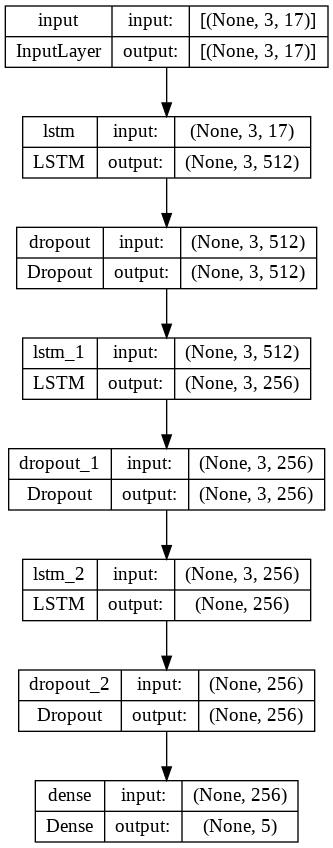

In [ ]:
model = LSTM_base(lookback_width=IW, num_features = len(scaled_data.columns),label_width=LW, loss = LOSS)
model.plot()

In [ ]:
model.train(data_window=wg, MAX_EPOCHS = MAX_EPOCHS, bs=bs, verbose=verbose, lr=lr, patience = patience)

Epoch 1/50
1/1 [==============================] - 7s 7s/step - loss: 0.2147 - val_loss: 1.2979
Epoch 2/50
1/1 [==============================] - 0s 165ms/step - loss: 0.2220 - val_loss: 1.2913
Epoch 3/50
1/1 [==============================] - 0s 141ms/step - loss: 0.2202 - val_loss: 1.2869
Epoch 4/50
1/1 [==============================] - 0s 143ms/step - loss: 0.2146 - val_loss: 1.2843
Epoch 5/50
1/1 [==============================] - 0s 144ms/step - loss: 0.2096 - val_loss: 1.2811
Epoch 6/50
1/1 [==============================] - 0s 149ms/step - loss: 0.2109 - val_loss: 1.2747
Epoch 7/50
1/1 [==============================] - 0s 141ms/step - loss: 0.2084 - val_loss: 1.2642
Epoch 8/50
1/1 [==============================] - 0s 134ms/step - loss: 0.2053 - val_loss: 1.2499
Epoch 9/50
1/1 [==============================] - 0s 157ms/step - loss: 0.2015 - val_loss: 1.2322
Epoch 10/50
1/1 [==============================] - 0s 142ms/step - loss: 0.1966 - val_loss: 1.2097
Epoch 11/50
1/1 [=====

In [ ]:
y_pred, y_real = fetch_pred_real(rbscaler, model)
print(
'MAE', list(MAE(y_pred, y_real)[0]), ' Mean MAE', MAE(y_pred, y_real)[1],
'\nMSE', list(MSE(y_pred, y_real)[0]),' Mean MSE', MSE(y_pred, y_real)[1],
'\nRMSE', list(RMSE(y_pred, y_real)[0]), 'Mean RMSE', RMSE(y_pred, y_real)[1]
)

1/1 [==============================] - 2s 2s/step
MAE [1.6216434, 2.1022923, 2.7147887, 3.3825178, 3.609766]  Mean MAE 2.686202 
MSE [3.9373188, 5.466326, 8.209171, 11.845391, 13.298505]  Mean MSE 8.551344 
RMSE [1.9842678, 2.3380177, 2.8651652, 3.4417133, 3.6467116] Mean RMSE 2.924268


2/2 [==============================] - 0s 19ms/step


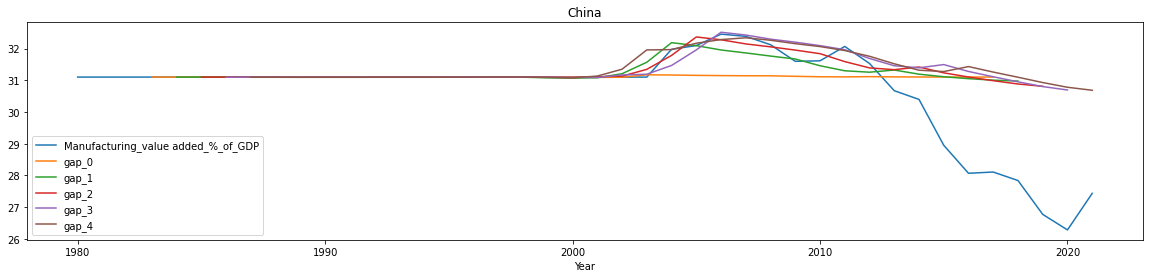

In [ ]:
y_pred, y_real = fetch_all_pred_real(rbscaler, model)
### predict 5 years at once (gap as prediction gap : 0, 1, 2, 3, 4)
pd.concat([data.iloc[:, -1], pat_pred(y_pred, data)], axis = 1).plot(figsize = (20, 4), title = 'China')

In [ ]:
forecast(rbscaler, scaled_data, model)

1/1 [==============================] - 3s 3s/step


Manufacturing_value added_%_of_GDP
2022                           31.095533
2023                           30.941828
2024                           30.630415
2025                           30.403395
2026                           30.253717

#### pipeline function

In [ ]:
SHIFT = 5
LW = 5
IW = 3
MAX_EPOCHS = 50
bs = 32
verbose = False
lr = 0.001
patience = 50
LOSS = tf.keras.losses.MeanAbsoluteError()

In [ ]:
def pipeline(country = 'CHN', method = 'Median'):
  data = m_dfs[(country, method)]
  # drop all column 0
  data = data.dropna(axis=1, how='all')
  # drop nan row according to target
  data = data[data[data.columns[-1]].notna()]
  data = data.fillna(data.median())
  rbscaler = MRobustScaler()
  scaled_data = rbscaler.transform(data, 0.1)
  train_df, val_df, test_df=train_test_split(scaled_data, IW = IW + SHIFT)
  wg = WindowGenerator(input_width=IW, label_width=LW, shift=SHIFT,
                      train_df = train_df, val_df = val_df, test_df = test_df, 
                      scaled_data = scaled_data,
                      label_columns=[scaled_data.columns[-1]])
  model = LSTM_base(lookback_width=IW, num_features = len(scaled_data.columns),label_width=LW, loss = LOSS)
  model.train(data_window=wg, MAX_EPOCHS = MAX_EPOCHS, bs=bs, verbose=verbose, lr=lr, patience = patience)
  y_pred, y_real = fetch_pred_real(rbscaler, model)
  print(
  'MAE', list(MAE(y_pred, y_real)[0]), ' Mean MAE', MAE(y_pred, y_real)[1],
  '\nMSE', list(MSE(y_pred, y_real)[0]),' Mean MSE', MSE(y_pred, y_real)[1],
  '\nRMSE', list(RMSE(y_pred, y_real)[0]), 'Mean RMSE', RMSE(y_pred, y_real)[1]
  )
  y_pred1, y_real1 = fetch_all_pred_real(rbscaler, model)
  ### predict 5 years at once (gap as prediction gap : 0, 1, 2, 3, 4)
  display(pd.concat([data.iloc[:, -1], pat_pred(y_pred1, data)], axis = 1).plot(figsize = (20, 4), title = dic_country[country] + ' (' +  method + ') :' \
                                                                         + '\nMean MAE: ' + str(MAE(y_pred, y_real)[1]) \
                                                                         + '\nMean MSE: ' + str(MSE(y_pred, y_real)[1]) \
                                                                         + '\nMean RMSE: ' + str(RMSE(y_pred, y_real)[1]) \
                                                                         ))
  display(forecast(rbscaler, scaled_data, model, name = country + '_' + method))
  return  MAE(y_pred, y_real)[1], MSE(y_pred, y_real)[1], RMSE(y_pred, y_real)[1]

Total Modelling Time:  22.456270456314087
1/1 [==============================] - 1s 1s/step
MAE [1.6013737, 2.0739086, 2.6173952, 3.2772598, 3.4501827]  Mean MAE 2.6040237 
MSE [3.8543568, 5.3949943, 7.6361327, 11.185939, 12.175328]  Mean MSE 8.04935 
RMSE [1.9632516, 2.3227127, 2.7633553, 3.3445387, 3.4893162] Mean RMSE 2.8371377
2/2 [==============================] - 0s 19ms/step


1/1 [==============================] - 1s 1s/step


CHN_Median
2022   31.050634
2023   30.947111
2024   30.550264
2025   30.470531
2026   30.248430

(2.6040237, 8.04935, 2.8371377)

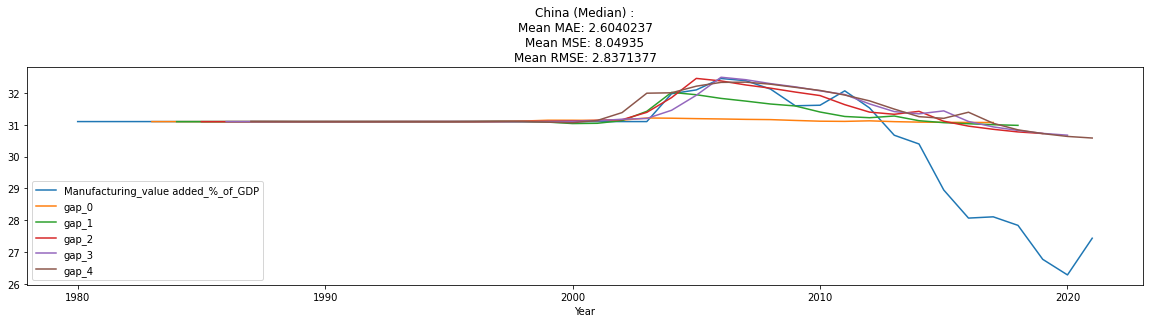

In [ ]:
pipeline()

#### Run all pipelines

##### Manufacturing

In [ ]:
c, m, a, s, r = [], [], [], [], []

###### Mean

Australia Mean :
Total Modelling Time:  15.235810279846191
1/1 [==============================] - 1s 1s/step
MAE [4.1064544, 5.0536213, 5.225993, 5.9017663, 5.3017545]  Mean MAE 5.1179175 
MSE [16.966608, 26.769844, 28.677149, 38.048115, 30.55735]  Mean MSE 28.203815 
RMSE [4.1190543, 5.1739583, 5.355105, 6.1683154, 5.52787] Mean RMSE 5.3107266
2/2 [==============================] - 0s 11ms/step


1/1 [==============================] - 1s 1s/step


AUS_Mean
2022  2.462733
2023  1.246720
2024  0.943161
2025 -0.205747
2026  2.105669



Brazil Mean :
Total Modelling Time:  15.280174493789673
1/1 [==============================] - 1s 1s/step
MAE [9.967518, 11.090253, 12.686817, 12.22416, 11.814326]  Mean MAE 11.556614 
MSE [100.4676, 124.617165, 164.00984, 154.29994, 142.78876]  Mean MSE 137.23666 
RMSE [10.023353, 11.163206, 12.806633, 12.421753, 11.949425] Mean RMSE 11.714806
2/2 [==============================] - 0s 13ms/step


1/1 [==============================] - 1s 1s/step


BRA_Mean
2022   5.965880
2023   6.760076
2024   8.250643
2025   9.320324
2026  11.230675



India Mean :
Total Modelling Time:  14.667532682418823
1/1 [==============================] - 1s 1s/step
MAE [2.0475678, 1.5989946, 0.8526127, 1.4313508, 2.3023498]  Mean MAE 1.6465753 
MSE [5.20183, 3.1225326, 0.9346757, 2.5236423, 7.6799607]  Mean MSE 3.8925283 
RMSE [2.280752, 1.767069, 0.96678627, 1.5885975, 2.771274] Mean RMSE 1.9729491
2/2 [==============================] - 0s 14ms/step


1/1 [==============================] - 1s 1s/step


CAN_Mean
2022  13.363016
2023  14.549078
2024  18.386795
2025  21.470057
2026  23.096863



China Mean :
Total Modelling Time:  15.074103832244873
1/1 [==============================] - 1s 1s/step
MAE [1.2324772, 1.2542957, 1.7036082, 2.3604667, 2.5652475]  Mean MAE 1.8232188 
MSE [1.9795111, 2.2093556, 3.5643542, 5.872711, 6.798392]  Mean MSE 4.084865 
RMSE [1.406951, 1.4863901, 1.8879497, 2.4233677, 2.6073725] Mean RMSE 2.0211048
2/2 [==============================] - 0s 13ms/step


1/1 [==============================] - 1s 1s/step


CHN_Mean
2022  30.122940
2023  29.882162
2024  29.403799
2025  29.107914
2026  28.861893



United Kingdom Mean :
Total Modelling Time:  15.64247465133667
1/1 [==============================] - 1s 1s/step
MAE [3.023957, 3.339874, 3.784558, 3.9277914, 3.9283648]  Mean MAE 3.600909 
MSE [20.042253, 22.934006, 23.381989, 21.854904, 20.24932]  Mean MSE 21.692493 
RMSE [4.4768577, 4.788946, 4.8354926, 4.674923, 4.499924] Mean RMSE 4.6575203
2/2 [==============================] - 0s 18ms/step


1/1 [==============================] - 1s 1s/step


GBR_Mean
2022  13.554306
2023  13.362785
2024  12.892798
2025  12.444163
2026  12.409939



India Mean :
Total Modelling Time:  18.883321046829224
1/1 [==============================] - 1s 1s/step
MAE [0.5238922, 0.606878, 1.4228511, 2.0678875, 2.434336]  Mean MAE 1.4111689 
MSE [0.4194089, 0.7873311, 3.415219, 5.884702, 7.079657]  Mean MSE 3.5172632 
RMSE [0.6476179, 0.8873168, 1.8480312, 2.4258406, 2.6607625] Mean RMSE 1.8754368
2/2 [==============================] - 0s 13ms/step


1/1 [==============================] - 1s 1s/step


IND_Mean
2022  15.763614
2023  15.653545
2024  15.521226
2025  15.554150
2026  15.687895



Japan Mean :
Total Modelling Time:  16.05889892578125
1/1 [==============================] - 1s 1s/step
MAE [1.3939037, 1.6394291, 1.4849329, 1.3196617, 1.067202]  Mean MAE 1.3810258 
MSE [2.5262299, 3.1002676, 2.4447095, 1.784989, 1.2892283]  Mean MSE 2.2290847 
RMSE [1.5894119, 1.7607577, 1.5635567, 1.3360348, 1.1354419] Mean RMSE 1.493012
2/2 [==============================] - 0s 13ms/step


1/1 [==============================] - 1s 1s/step


JPN_Mean
2022  20.003082
2023  20.056145
2024  20.465155
2025  20.525564
2026  20.288918



Singapore Mean :
Total Modelling Time:  14.225678443908691
1/1 [==============================] - 1s 1s/step
MAE [4.4345074, 3.7995007, 3.114995, 2.5757067, 1.6036491]  Mean MAE 3.105672 
MSE [19.869083, 16.108452, 11.398366, 7.9633536, 3.6618927]  Mean MSE 11.800231 
RMSE [4.457475, 4.0135336, 3.3761466, 2.8219414, 1.9136072] Mean RMSE 3.4351463
2/2 [==============================] - 0s 15ms/step


1/1 [==============================] - 2s 2s/step


SGP_Mean
2022  19.071442
2023  19.119736
2024  18.896158
2025  19.941742
2026  22.142118



United States Mean :
Total Modelling Time:  14.965114831924438
1/1 [==============================] - 1s 1s/step
MAE [0.6951907, 0.95439243, 0.6389521, 0.41622815, 0.6074012]  Mean MAE 0.6624329 
MSE [0.4969326, 0.95904917, 0.44124076, 0.19778068, 0.45582947]  Mean MSE 0.5101665 
RMSE [0.7049345, 0.9793106, 0.66425955, 0.4447254, 0.67515147] Mean RMSE 0.71425945
2/2 [==============================] - 0s 15ms/step


1/1 [==============================] - 1s 1s/step


USA_Mean
2022  11.768032
2023  13.199572
2024  16.066000
2025  18.355850
2026  17.442612

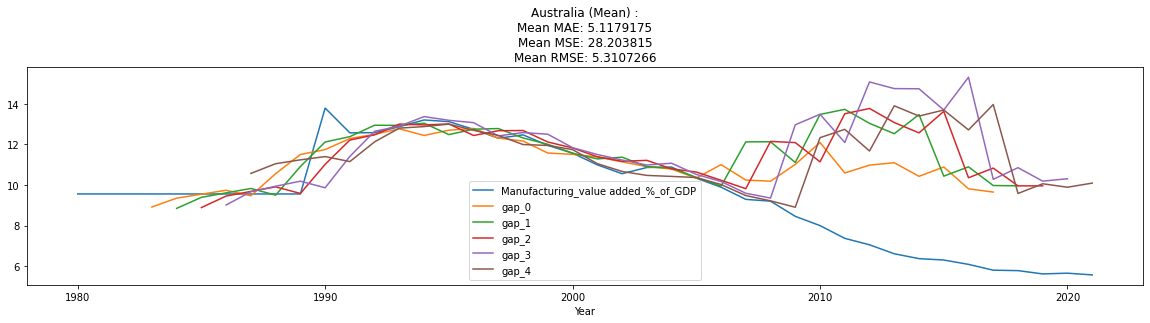

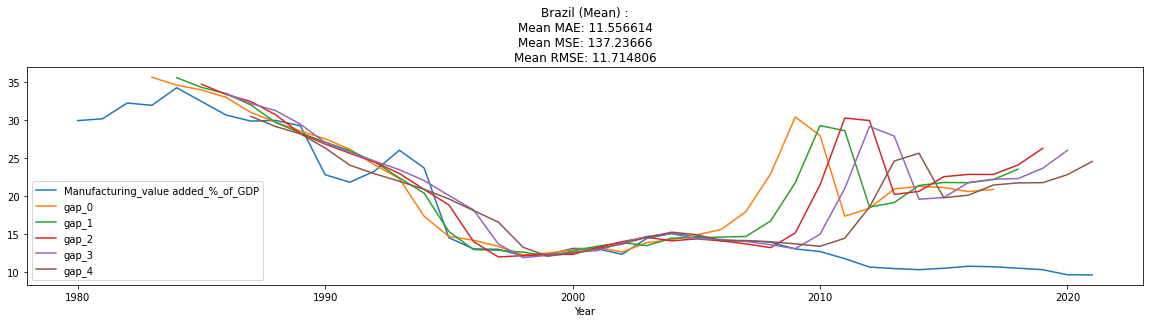

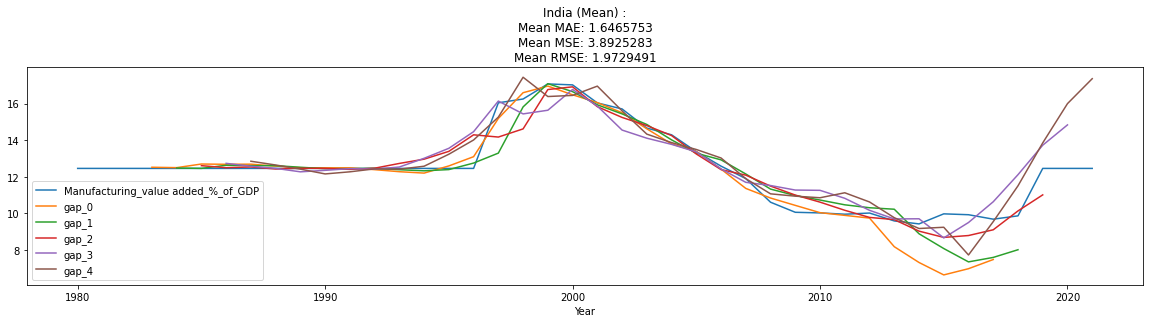

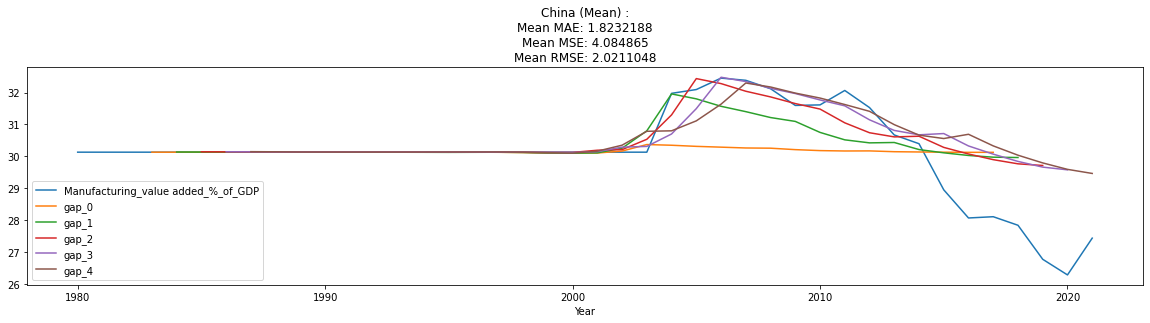

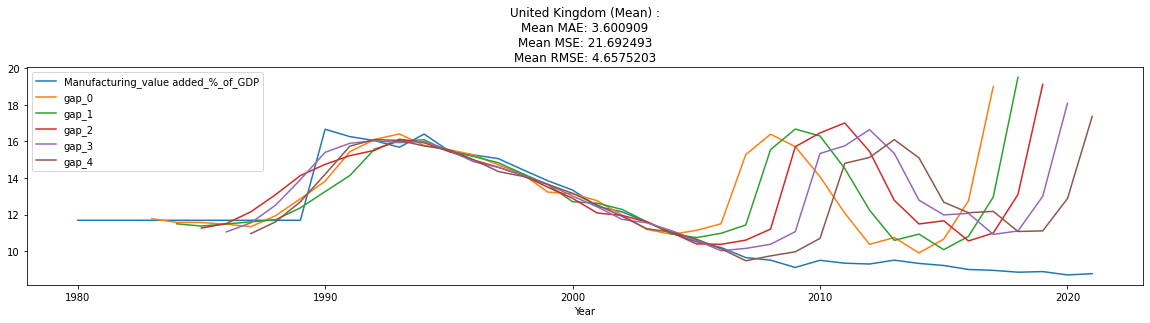

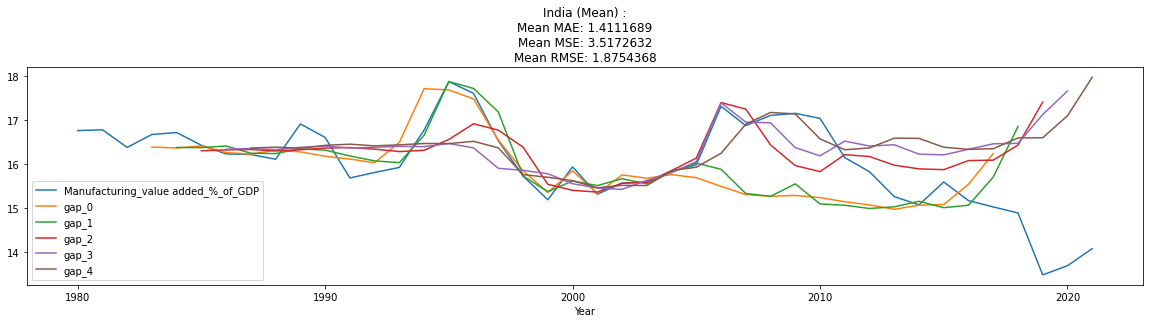

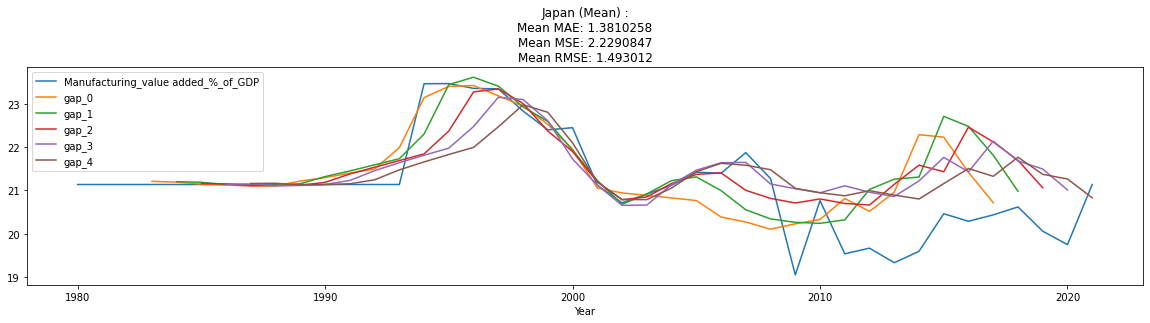

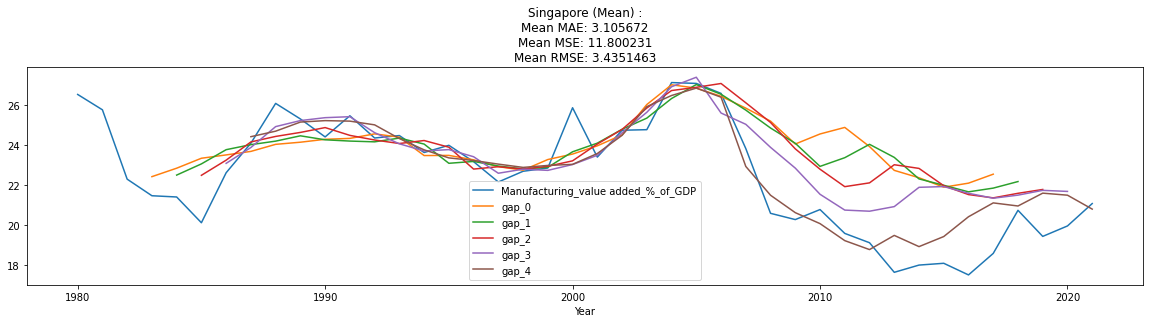

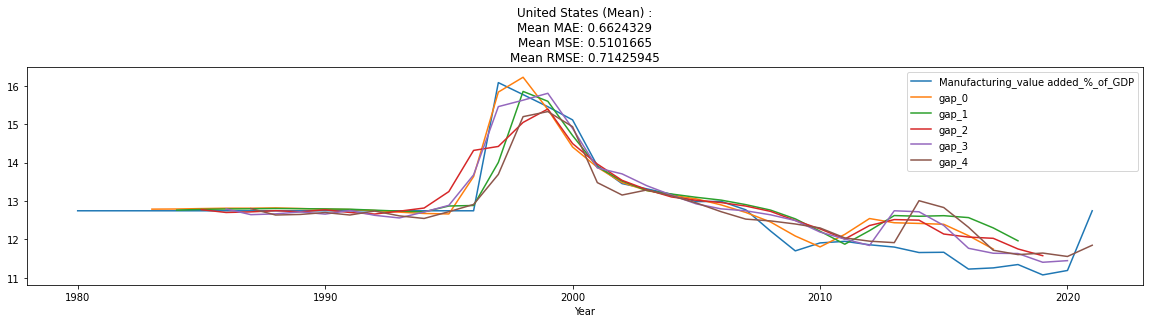

In [ ]:
for sheet in get_sheet_by_methods(Data_dic_m, 0):
  country = sheet[:3]
  method = sheet[3:].strip()
  print(dic_country[country], method, ':')
  a1, s1, r1 = pipeline(country, method)
  c.append(country)
  m.append(method)
  a.append(a1)
  s.append(s1)
  r.append(r1)
  print('\n')

###### Median

Australia Median :
Total Modelling Time:  16.9752357006073
1/1 [==============================] - 1s 1s/step
MAE [3.2363894, 3.8759835, 4.1082335, 4.544061, 4.9427257]  Mean MAE 4.141479 
MSE [11.027911, 15.343262, 17.213043, 20.90333, 24.712128]  Mean MSE 17.839935 
RMSE [3.3208299, 3.9170475, 4.1488605, 4.572016, 4.9711294] Mean RMSE 4.223735
2/2 [==============================] - 0s 14ms/step


1/1 [==============================] - 1s 1s/step


AUS_Median
2022    8.729439
2023    8.546609
2024    8.500109
2025    8.340132
2026    8.482519



Brazil Median :
Total Modelling Time:  16.371171951293945
1/1 [==============================] - 1s 1s/step
MAE [7.396628, 5.4327264, 5.949879, 4.491596, 4.518262]  Mean MAE 5.5578184 
MSE [55.8729, 32.47344, 39.24352, 29.044321, 26.401215]  Mean MSE 36.60708 
RMSE [7.4748178, 5.698547, 6.264465, 5.3892784, 5.1382113] Mean RMSE 6.0503783
2/2 [==============================] - 0s 16ms/step


1/1 [==============================] - 1s 1s/step


BRA_Median
2022    7.335187
2023    7.611885
2024    8.768217
2025    8.917763
2026   11.574614



India Median :
Total Modelling Time:  16.591110706329346
1/1 [==============================] - 1s 1s/step
MAE [2.2000382, 1.7220942, 1.2920424, 0.69121313, 1.2107936]  Mean MAE 1.4232364 
MSE [5.576513, 3.4864292, 1.9207387, 0.6861973, 2.1291616]  Mean MSE 2.759808 
RMSE [2.361464, 1.8671982, 1.3859072, 0.8283703, 1.4591647] Mean RMSE 1.661267
2/2 [==============================] - 0s 13ms/step


1/1 [==============================] - 1s 1s/step


CAN_Median
2022   13.880498
2023   16.987263
2024   18.238428
2025   17.916620
2026   20.539522



China Median :
Total Modelling Time:  14.986695051193237
1/1 [==============================] - 1s 1s/step
MAE [1.6251541, 2.0254748, 2.588603, 3.2406628, 3.4850252]  Mean MAE 2.592984 
MSE [3.949052, 5.204988, 7.6056695, 11.008454, 12.443252]  Mean MSE 8.042283 
RMSE [1.9872222, 2.2814443, 2.7578378, 3.317899, 3.5274994] Mean RMSE 2.835892
2/2 [==============================] - 0s 14ms/step


1/1 [==============================] - 2s 2s/step


CHN_Median
2022   31.101070
2023   30.873568
2024   30.607090
2025   30.454865
2026   30.423975



United Kingdom Median :
Total Modelling Time:  16.347013235092163
1/1 [==============================] - 1s 1s/step
MAE [1.6199275, 2.055075, 2.3744664, 2.4737256, 2.4068964]  Mean MAE 2.1860182 
MSE [6.588013, 10.467038, 12.582611, 12.161003, 9.831737]  Mean MSE 10.32608 
RMSE [2.5667126, 3.2352803, 3.5471976, 3.487263, 3.13556] Mean RMSE 3.2134218
2/2 [==============================] - 0s 15ms/step


1/1 [==============================] - 1s 1s/step


GBR_Median
2022   11.627062
2023   11.652777
2024   11.426628
2025   11.031335
2026   10.743282



India Median :
Total Modelling Time:  16.022342443466187
1/1 [==============================] - 1s 1s/step
MAE [0.273952, 0.24817593, 1.188841, 1.8522125, 2.244757]  Mean MAE 1.1615878 
MSE [0.15499617, 0.08638356, 1.9779905, 4.3621817, 5.593291]  Mean MSE 2.4349687 
RMSE [0.39369553, 0.2939108, 1.4064105, 2.0885837, 2.3650138] Mean RMSE 1.5604386
2/2 [==============================] - 0s 17ms/step


1/1 [==============================] - 1s 1s/step


IND_Median
2022   15.619692
2023   15.329524
2024   15.432002
2025   15.412004
2026   15.624089



Japan Median :
Total Modelling Time:  15.59908652305603
1/1 [==============================] - 1s 1s/step
MAE [1.1867056, 1.3439859, 1.193718, 1.1166426, 1.0115534]  Mean MAE 1.170521 
MSE [1.9284228, 2.203396, 1.6671915, 1.3017792, 1.1573173]  Mean MSE 1.6516213 
RMSE [1.3886766, 1.4843841, 1.2911977, 1.1409553, 1.0757868] Mean RMSE 1.2851542
2/2 [==============================] - 0s 22ms/step


1/1 [==============================] - 1s 1s/step


JPN_Median
2022   19.602442
2023   19.662390
2024   20.192303
2025   20.238239
2026   20.012079



Singapore Median :
Total Modelling Time:  14.442829132080078
1/1 [==============================] - 2s 2s/step
MAE [4.7422976, 4.412861, 4.0266123, 3.4245222, 2.164202]  Mean MAE 3.7540987 
MSE [22.663307, 21.448412, 17.766762, 12.719989, 5.796309]  Mean MSE 16.078957 
RMSE [4.7605996, 4.631243, 4.2150636, 3.5665092, 2.4075525] Mean RMSE 4.0098577
2/2 [==============================] - 0s 16ms/step


1/1 [==============================] - 1s 1s/step


SGP_Median
2022   20.338436
2023   19.932087
2024   20.245789
2025   21.122316
2026   22.718410



United States Median :
Total Modelling Time:  15.003186702728271
1/1 [==============================] - 1s 1s/step
MAE [0.25232872, 0.27930132, 0.31599918, 0.9150262, 1.3044304]  Mean MAE 0.6134172 
MSE [0.07185996, 0.097981684, 0.1428886, 1.0201273, 2.4465733]  Mean MSE 0.7558862 
RMSE [0.2680671, 0.31302026, 0.3780061, 1.0100135, 1.5641526] Mean RMSE 0.86941713
2/2 [==============================] - 0s 18ms/step


1/1 [==============================] - 1s 1s/step


USA_Median
2022   10.304330
2023   11.302414
2024   13.433897
2025   15.446472
2026   16.434193

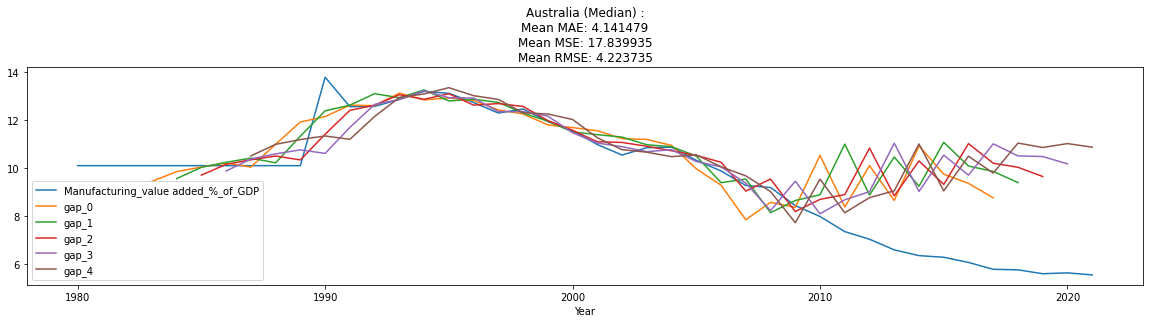

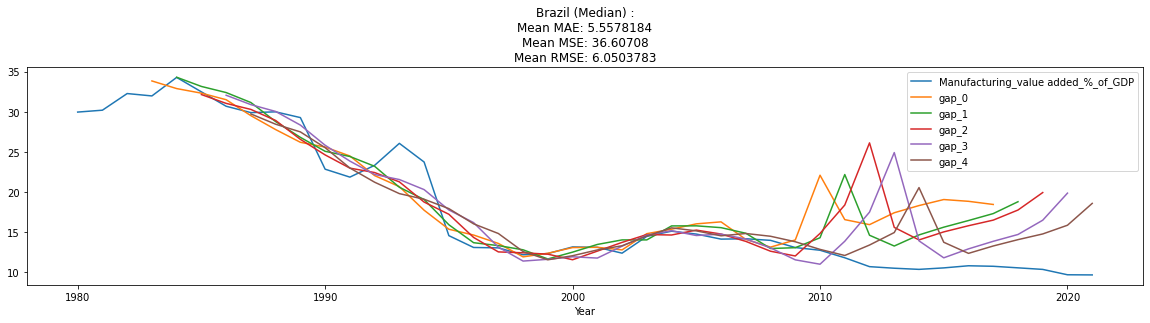

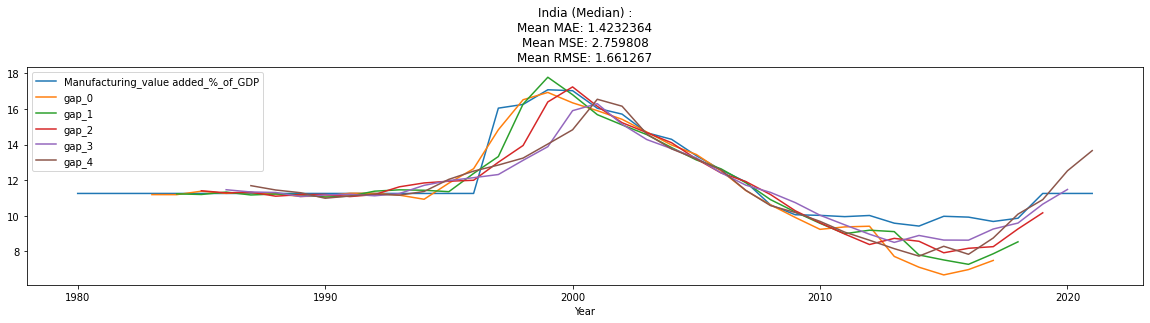

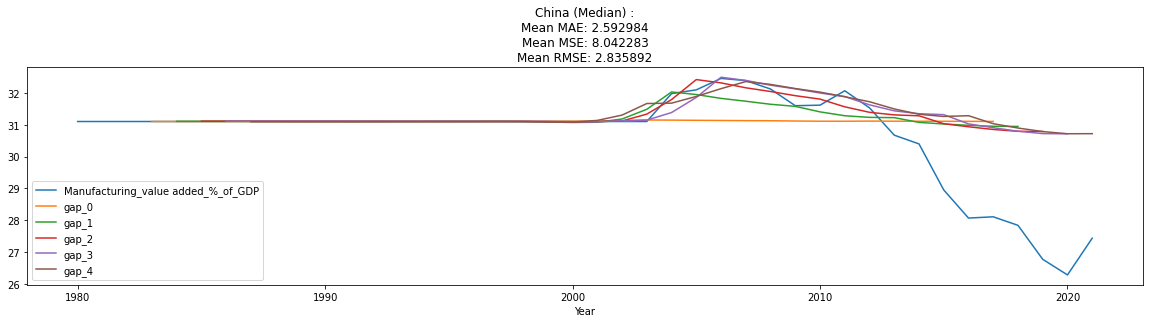

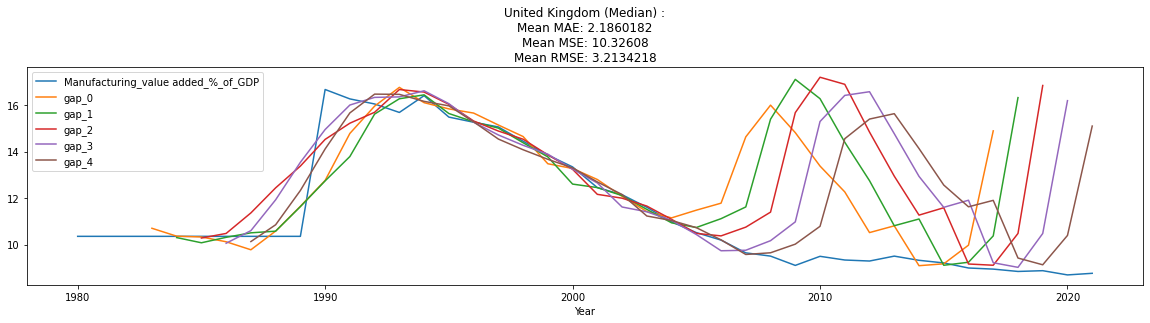

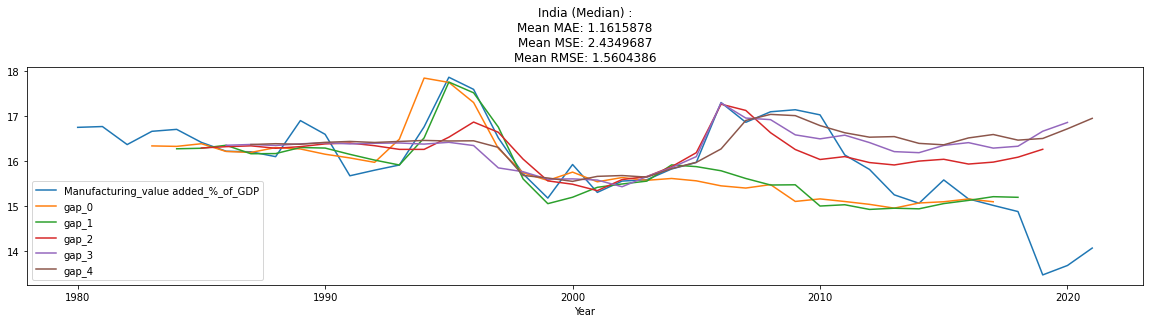

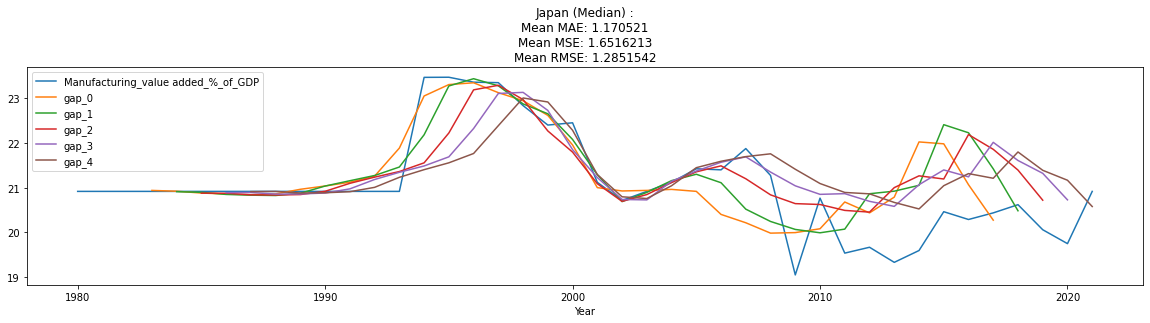

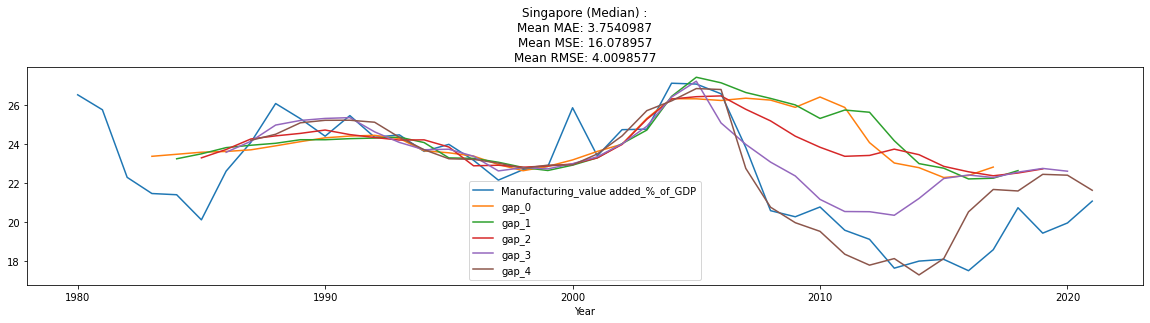

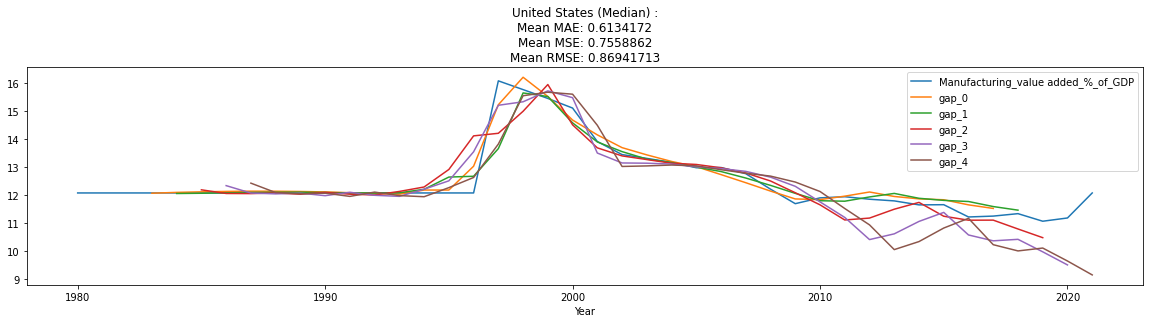

In [ ]:
for sheet in get_sheet_by_methods(Data_dic_m, 1):
  country = sheet[:3]
  method = sheet[3:].strip()
  print(dic_country[country], method, ':')
  a1, s1, r1 = pipeline(country, method)
  c.append(country)
  m.append(method)
  a.append(a1)
  s.append(s1)
  r.append(r1)
  print('\n')

###### LOCF

Australia LOCF :
Total Modelling Time:  14.566658973693848
1/1 [==============================] - 1s 1s/step
MAE [2.7542148, 2.6705728, 2.1951947, 2.141929, 2.3345082]  Mean MAE 2.4192839 
MSE [7.8994393, 7.4644403, 5.535276, 5.2520804, 5.8690124]  Mean MSE 6.404049 
RMSE [2.810594, 2.732113, 2.3527167, 2.2917418, 2.4226046] Mean RMSE 2.5306222
1/1 [==============================] - 0s 72ms/step


1/1 [==============================] - 1s 1s/step


AUS_LOCF
2022  14.047377
2023  14.515348
2024  14.027593
2025  13.671597
2026  13.808149



Brazil LOCF :
Total Modelling Time:  15.871428966522217
1/1 [==============================] - 1s 1s/step
MAE [13.052909, 16.153688, 15.860394, 18.229984, 17.931849]  Mean MAE 16.245764 
MSE [177.84544, 273.97055, 263.90076, 351.9838, 344.2557]  Mean MSE 282.39124 
RMSE [13.335871, 16.552055, 16.245022, 18.76123, 18.554129] Mean RMSE 16.8045
2/2 [==============================] - 0s 14ms/step


1/1 [==============================] - 1s 1s/step


BRA_LOCF
2022  3.180504
2023  4.777135
2024  6.222589
2025  7.730859
2026  9.693192



India LOCF :
Total Modelling Time:  14.635260105133057
1/1 [==============================] - 1s 1s/step
MAE [0.38643384, 0.40469027, 0.33039975, 0.19119835, 0.21425629]  Mean MAE 0.3053957 
MSE [0.19451393, 0.2482467, 0.15075836, 0.066378266, 0.060583368]  Mean MSE 0.14409612 
RMSE [0.44103733, 0.4982436, 0.38827613, 0.2576398, 0.24613689] Mean RMSE 0.37959996
1/1 [==============================] - 0s 61ms/step


1/1 [==============================] - 1s 1s/step


CAN_LOCF
2022  11.077131
2023  10.949958
2024  10.974855
2025  10.863920
2026  10.841392



China LOCF :
Total Modelling Time:  14.932437181472778
1/1 [==============================] - 1s 1s/step
MAE [3.6491516, 3.386626, 2.3855922, 2.773135, 1.7136549]  Mean MAE 2.781632 
MSE [13.345119, 11.640854, 6.989399, 8.574028, 3.4256704]  Mean MSE 8.795014 
RMSE [3.6530972, 3.4118695, 2.643747, 2.9281442, 1.8508567] Mean RMSE 2.9656389
1/1 [==============================] - 0s 64ms/step


1/1 [==============================] - 1s 1s/step


CHN_LOCF
2022  31.102343
2023  31.260979
2024  31.031322
2025  30.889709
2026  31.348368



United Kingdom LOCF :
Total Modelling Time:  14.604358196258545
1/1 [==============================] - 1s 1s/step
MAE [0.42201024, 0.4943058, 0.45932007, 0.9339117, 0.8653517]  Mean MAE 0.6349799 
MSE [0.30420297, 0.50059927, 0.4588017, 1.2949789, 1.1287906]  Mean MSE 0.7374747 
RMSE [0.551546, 0.7075304, 0.67734903, 1.1379714, 1.0624456] Mean RMSE 0.85876346
1/1 [==============================] - 0s 73ms/step


1/1 [==============================] - 1s 1s/step


GBR_LOCF
2022  12.447744
2023  12.810181
2024  12.982618
2025  12.923967
2026  13.145493



India LOCF :
Total Modelling Time:  14.65921926498413
1/1 [==============================] - 1s 1s/step
MAE [0.7349227, 0.41478968, 0.75450164, 1.8195108, 2.607908]  Mean MAE 1.2663268 
MSE [0.64075047, 0.2180838, 1.0596596, 3.765627, 7.25409]  Mean MSE 2.5876424 
RMSE [0.8004689, 0.46699443, 1.0293977, 1.9405223, 2.6933417] Mean RMSE 1.608615
2/2 [==============================] - 0s 13ms/step


1/1 [==============================] - 1s 1s/step


IND_LOCF
2022  16.912842
2023  16.211987
2024  15.646307
2025  15.123896
2026  14.811608



Japan LOCF :
Total Modelling Time:  14.90265965461731
1/1 [==============================] - 1s 1s/step
MAE [0.78508234, 0.9603648, 0.9609413, 1.0201535, 1.1362963]  Mean MAE 0.9725677 
MSE [1.1529819, 1.381259, 1.1471977, 1.3139055, 1.7818735]  Mean MSE 1.3554435 
RMSE [1.0737699, 1.1752697, 1.0710732, 1.1462572, 1.3348683] Mean RMSE 1.1642351
1/1 [==============================] - 0s 65ms/step


1/1 [==============================] - 1s 1s/step


JPN_LOCF
2022  20.169460
2023  20.856127
2024  21.243641
2025  22.327028
2026  22.316441



Singapore LOCF :
Total Modelling Time:  16.35957431793213
1/1 [==============================] - 1s 1s/step
MAE [4.592522, 4.1661906, 4.0761867, 3.8431737, 2.563859]  Mean MAE 3.848386 
MSE [21.286188, 19.196333, 18.223402, 15.761529, 7.533552]  Mean MSE 16.400202 
RMSE [4.6136956, 4.381362, 4.2688875, 3.9700792, 2.7447317] Mean RMSE 4.0497165
2/2 [==============================] - 0s 13ms/step


1/1 [==============================] - 1s 1s/step


SGP_LOCF
2022  20.060356
2023  19.819185
2024  19.777302
2025  21.060375
2026  22.695774



United States LOCF :
Total Modelling Time:  13.744423389434814
1/1 [==============================] - 1s 1s/step
MAE [0.48483706, 0.47146177, 0.5787177, 0.65148735, 0.72716236]  Mean MAE 0.5827333 
MSE [0.24851748, 0.2468242, 0.34537297, 0.43834698, 0.54196787]  Mean MSE 0.3642059 
RMSE [0.49851528, 0.49681404, 0.5876844, 0.6620778, 0.73618466] Mean RMSE 0.60349476
1/1 [==============================] - 0s 63ms/step


1/1 [==============================] - 1s 1s/step


USA_LOCF
2022  11.768915
2023  11.702687
2024  11.737102
2025  11.877629
2026  11.958547

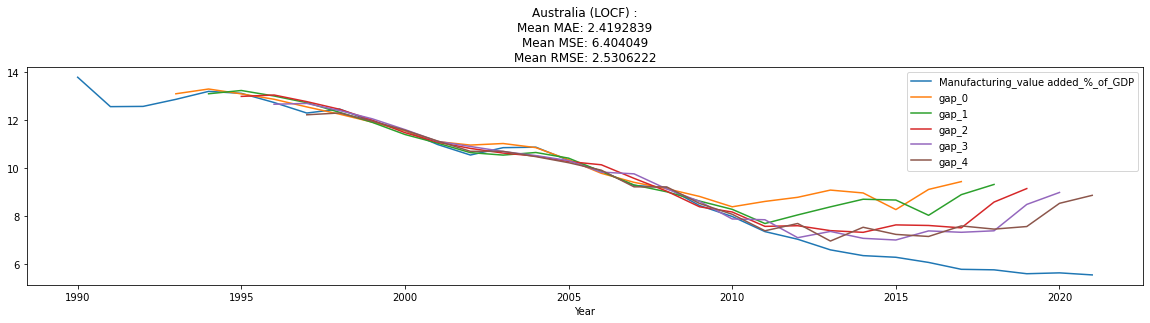

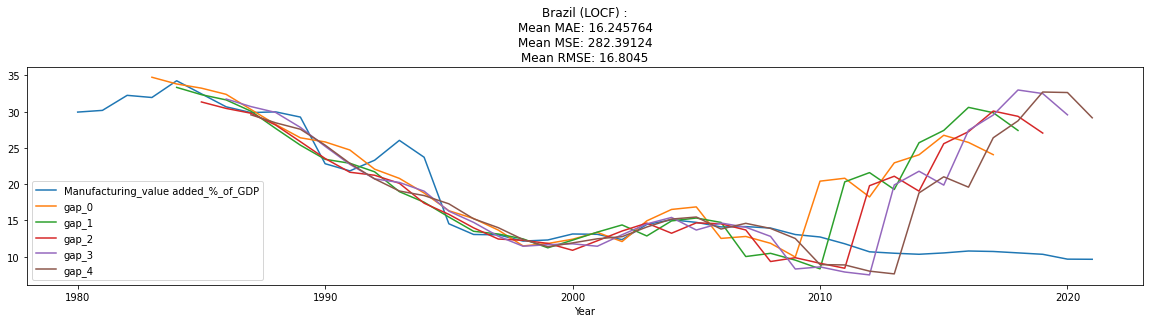

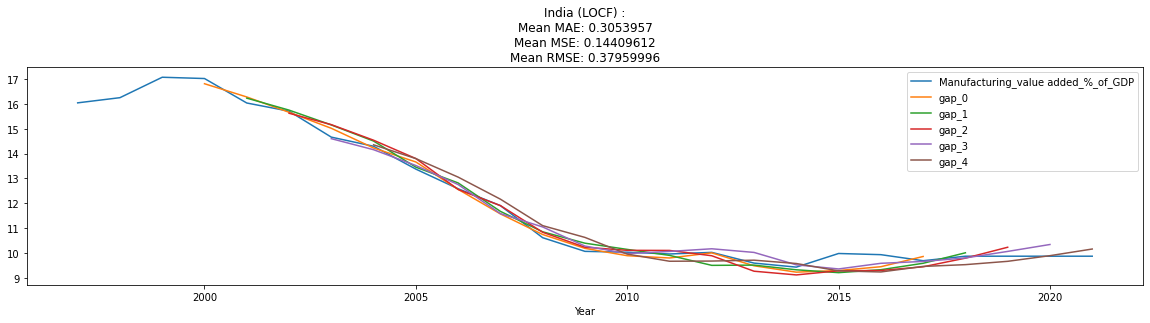

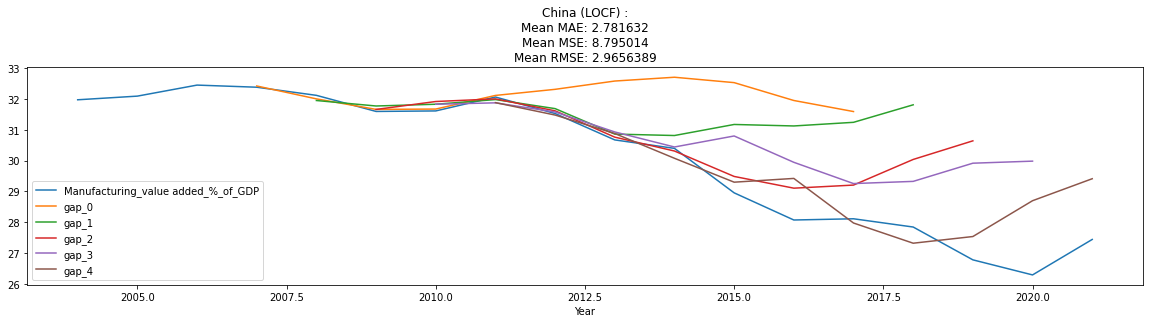

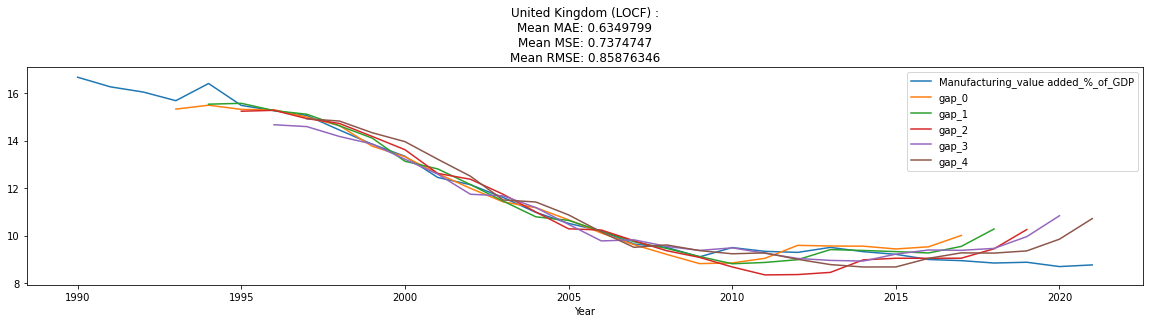

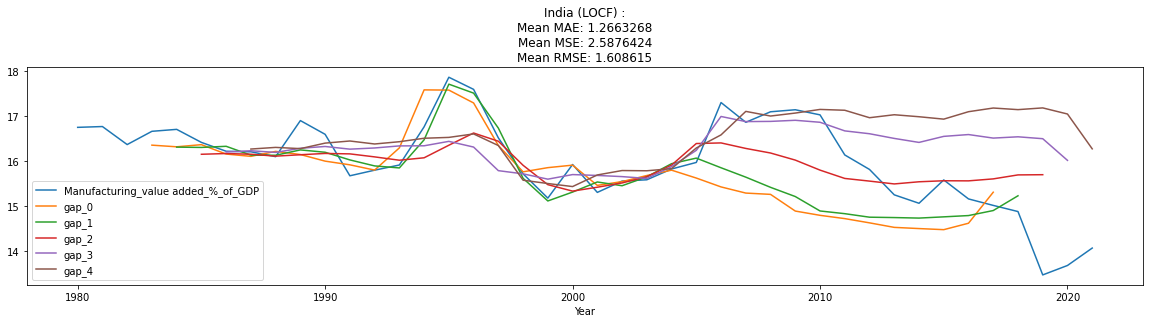

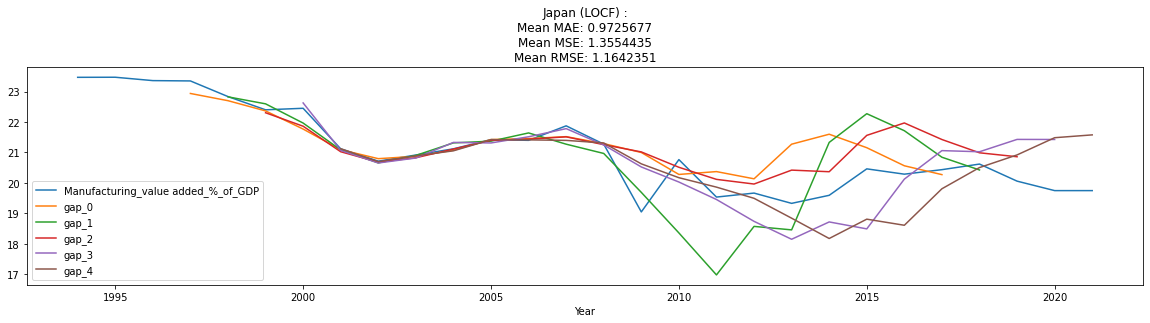

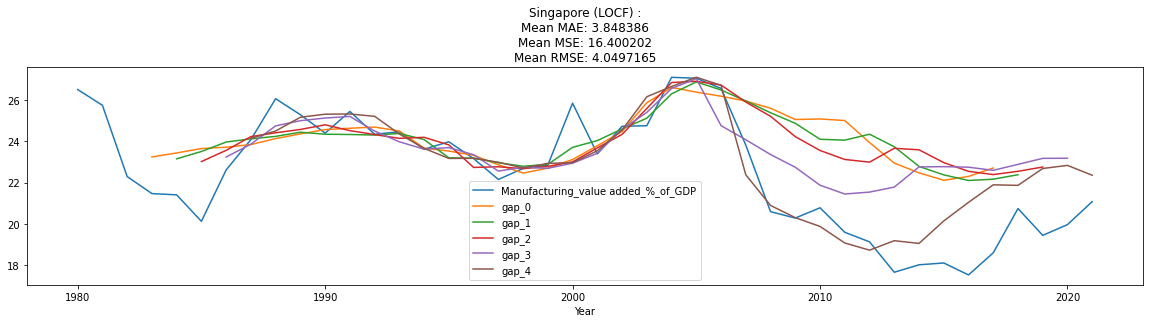

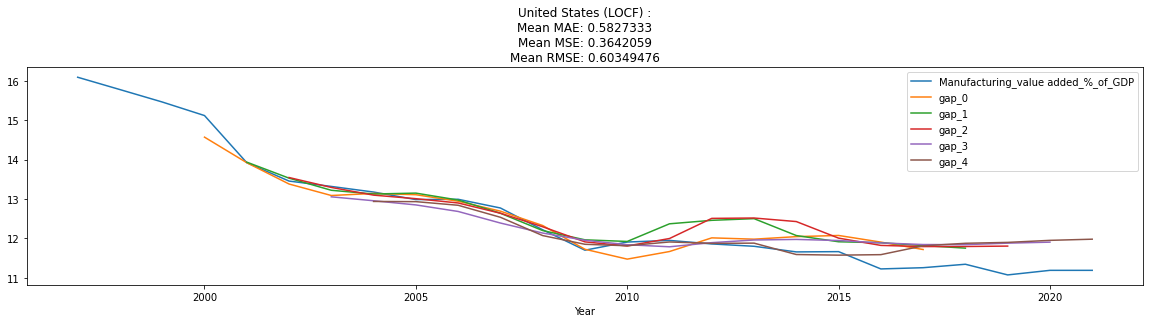

In [ ]:
for sheet in get_sheet_by_methods(Data_dic_m, 2):
  country = sheet[:3]
  method = sheet[3:].strip()
  print(dic_country[country], method, ':')
  try:
    a1, s1, r1 = pipeline(country, method)
    c.append(country)
    m.append(method)
    a.append(a1)
    s.append(s1)
    r.append(r1)
    print('\n')
  except:
    print(f'Cannot handle {country}, {method}')

###### NOCB

Australia NOCB :
Total Modelling Time:  15.909523487091064
1/1 [==============================] - 1s 1s/step
MAE [3.7447631, 3.7953575, 3.110544, 2.4608824, 2.4738376]  Mean MAE 3.117077 
MSE [14.185802, 14.515643, 10.863843, 8.562419, 8.543494]  Mean MSE 11.334241 
RMSE [3.7664044, 3.80994, 3.2960343, 2.926161, 2.9229257] Mean RMSE 3.3666365
2/2 [==============================] - 0s 15ms/step


1/1 [==============================] - 2s 2s/step


AUS_NOCB
2022  13.835822
2023  12.412455
2024   8.422340
2025   6.509796
2026   6.563680



Brazil NOCB :
Total Modelling Time:  15.730259418487549
1/1 [==============================] - 1s 1s/step
MAE [10.250127, 11.688881, 11.811958, 14.716311, 16.7594]  Mean MAE 13.045335 
MSE [106.93644, 139.41437, 142.86964, 223.23521, 292.61722]  Mean MSE 181.01459 
RMSE [10.341007, 11.807386, 11.952809, 14.941058, 17.106058] Mean RMSE 13.454166
2/2 [==============================] - 0s 16ms/step


1/1 [==============================] - 1s 1s/step


BRA_NOCB
2022   9.183369
2023   9.751078
2024   9.371675
2025  10.000080
2026  10.463846



India NOCB :
Total Modelling Time:  16.04499363899231
1/1 [==============================] - 1s 1s/step
MAE [5.2368875, 4.1138225, 5.2679605, 7.2063584, 9.518189]  Mean MAE 6.268644 
MSE [27.488276, 16.95121, 27.820724, 52.08076, 91.338005]  Mean MSE 43.135796 
RMSE [5.242926, 4.1171846, 5.2745357, 7.2167, 9.557092] Mean RMSE 6.567785
1/1 [==============================] - 0s 74ms/step


1/1 [==============================] - 1s 1s/step


CAN_NOCB
2019  15.871582
2020  15.722952
2021  16.086061
2022  16.810347
2023  17.788969



China NOCB :
Total Modelling Time:  17.32065463066101
1/1 [==============================] - 1s 1s/step
MAE [2.4074562, 3.26431, 4.4798274, 5.911461, 5.8740826]  Mean MAE 4.387428 
MSE [7.5318313, 11.956292, 21.312645, 35.61998, 35.033104]  Mean MSE 22.29077 
RMSE [2.7444181, 3.4577873, 4.616562, 5.9682474, 5.918877] Mean RMSE 4.72131
2/2 [==============================] - 0s 13ms/step


1/1 [==============================] - 1s 1s/step


CHN_NOCB
2022  32.001938
2023  32.143677
2024  32.450718
2025  32.819206
2026  32.660057



United Kingdom NOCB :
Total Modelling Time:  15.906858682632446
1/1 [==============================] - 2s 2s/step
MAE [5.309485, 5.8527007, 6.2685533, 6.571769, 7.1306243]  Mean MAE 6.226626 
MSE [31.945473, 38.230984, 43.697826, 47.58905, 55.864452]  Mean MSE 43.46556 
RMSE [5.652033, 6.1831207, 6.610433, 6.898482, 7.4742527] Mean RMSE 6.5928416
2/2 [==============================] - 0s 13ms/step


1/1 [==============================] - 1s 1s/step


GBR_NOCB
2022  2.839498
2023  2.156377
2024  1.653754
2025  1.255525
2026  0.479521



India NOCB :
Total Modelling Time:  14.825302362442017
1/1 [==============================] - 1s 1s/step
MAE [0.6699117, 1.0879053, 3.2476976, 3.875747, 4.7356086]  Mean MAE 2.723374 
MSE [0.4919711, 1.5211767, 13.429324, 17.96518, 24.717438]  Mean MSE 11.625017 
RMSE [0.70140654, 1.2333599, 3.6646042, 4.238535, 4.9716635] Mean RMSE 3.409548
2/2 [==============================] - 0s 14ms/step


1/1 [==============================] - 1s 1s/step


IND_NOCB
2022  14.579254
2023  16.377041
2024  18.264517
2025  18.610580
2026  19.177715



Japan NOCB :
Total Modelling Time:  15.762178182601929
1/1 [==============================] - 1s 1s/step
MAE [2.2345388, 2.2482483, 2.2336903, 2.3116543, 2.426153]  Mean MAE 2.2908568 
MSE [5.483501, 5.339571, 5.350495, 5.766255, 6.4911675]  Mean MSE 5.6861973 
RMSE [2.3416877, 2.3107512, 2.3131137, 2.4013028, 2.547777] Mean RMSE 2.384575
2/2 [==============================] - 0s 16ms/step


1/1 [==============================] - 1s 1s/step


JPN_NOCB
2021  20.969757
2022  21.291790
2023  21.725750
2024  22.346256
2025  22.706829



Singapore NOCB :
Total Modelling Time:  15.87492823600769
1/1 [==============================] - 1s 1s/step
MAE [4.1343837, 3.8047333, 5.8451934, 7.301004, 7.0194244]  Mean MAE 5.6209483 
MSE [17.418047, 17.011875, 35.479736, 54.263683, 49.839752]  Mean MSE 34.802616 
RMSE [4.1734934, 4.1245456, 5.9564867, 7.366389, 7.0597277] Mean RMSE 5.899374
2/2 [==============================] - 0s 14ms/step


1/1 [==============================] - 1s 1s/step


SGP_NOCB
2022  18.336960
2023  17.064396
2024  20.526421
2025  25.610422
2026  28.775135



United States NOCB :
Total Modelling Time:  15.484041213989258
1/1 [==============================] - 1s 1s/step
MAE [1.2375997, 1.2706404, 1.4897634, 1.6228027, 1.6199269]  Mean MAE 1.4481467 
MSE [1.5445517, 1.656569, 2.2782335, 2.672431, 2.7685976]  Mean MSE 2.1840768 
RMSE [1.2428, 1.2870777, 1.5093819, 1.6347572, 1.6639104] Mean RMSE 1.4778622
2/2 [==============================] - 0s 13ms/step


1/1 [==============================] - 1s 1s/step


USA_NOCB
2021  10.255402
2022  10.287702
2023  10.113119
2024   9.526621
2025   8.375580

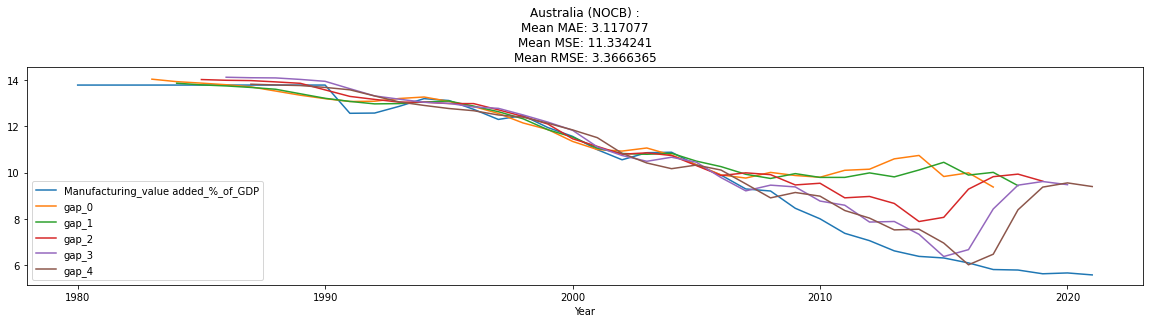

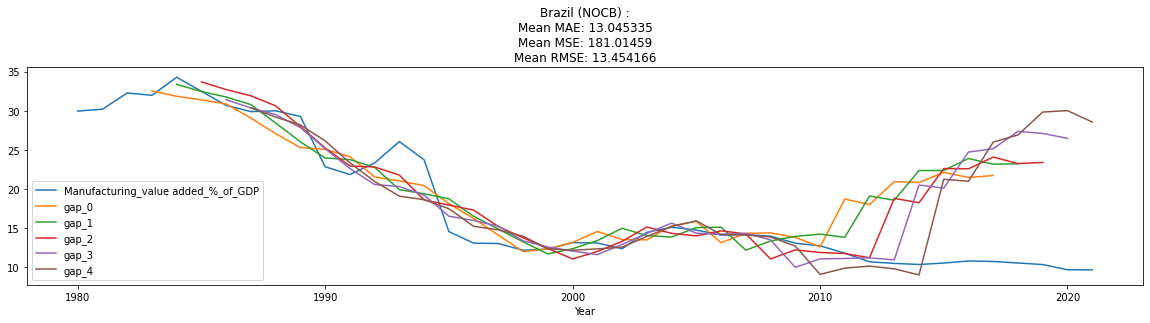

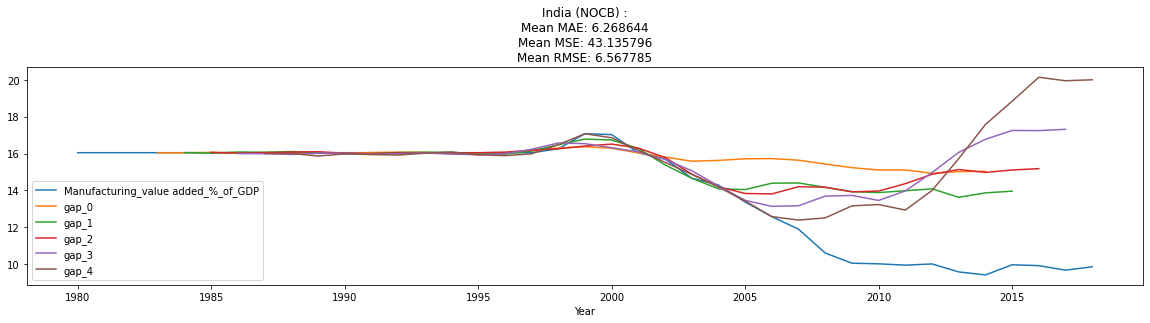

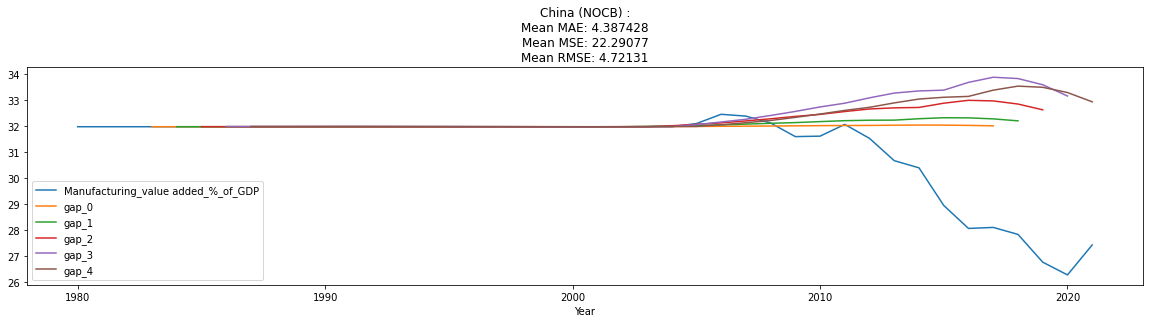

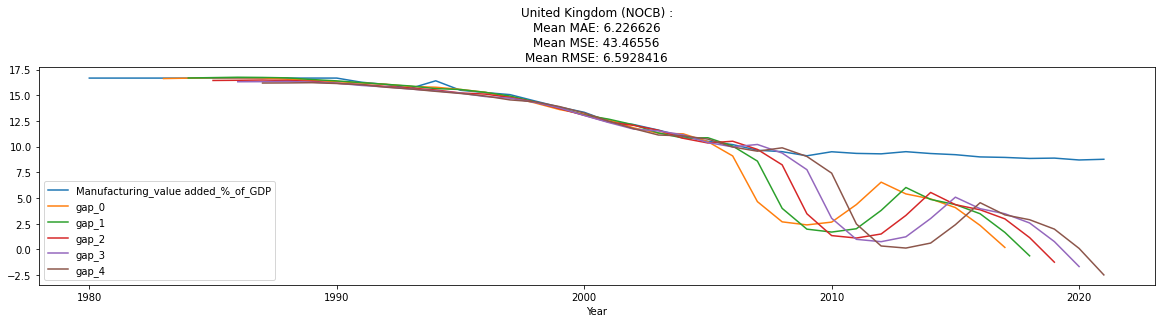

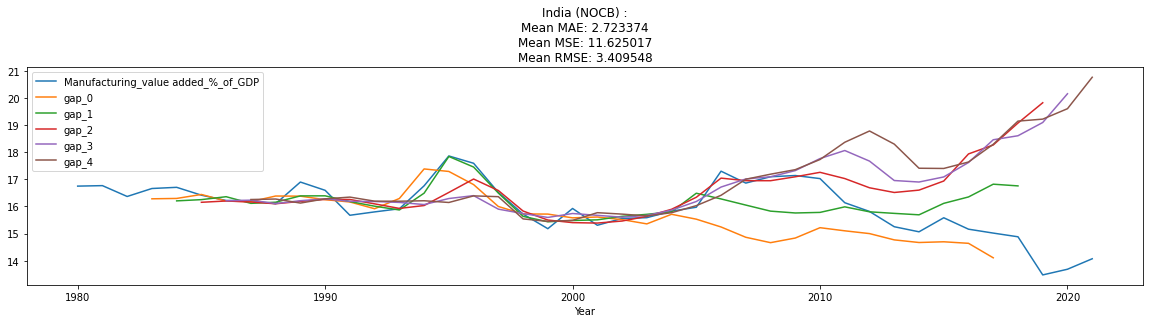

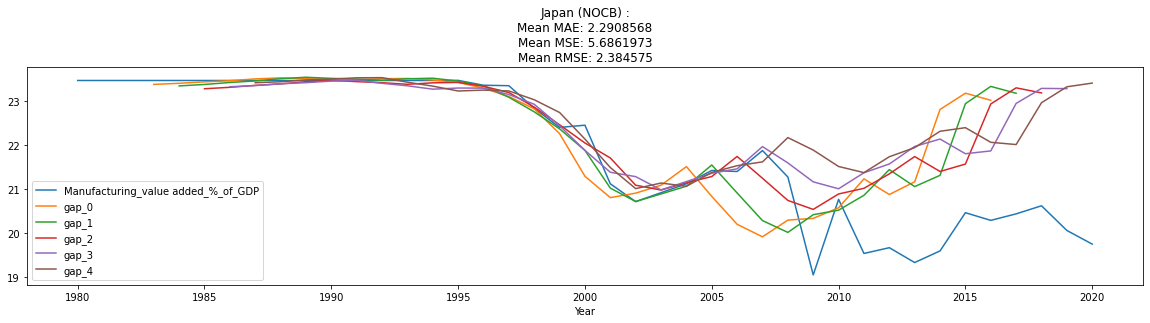

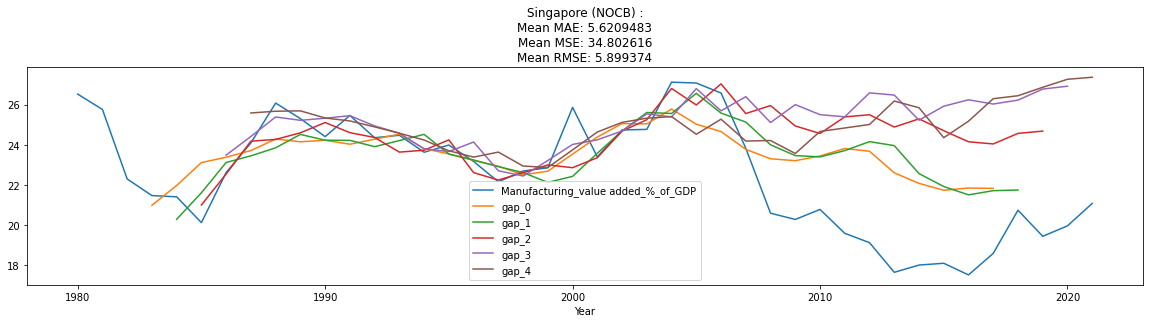

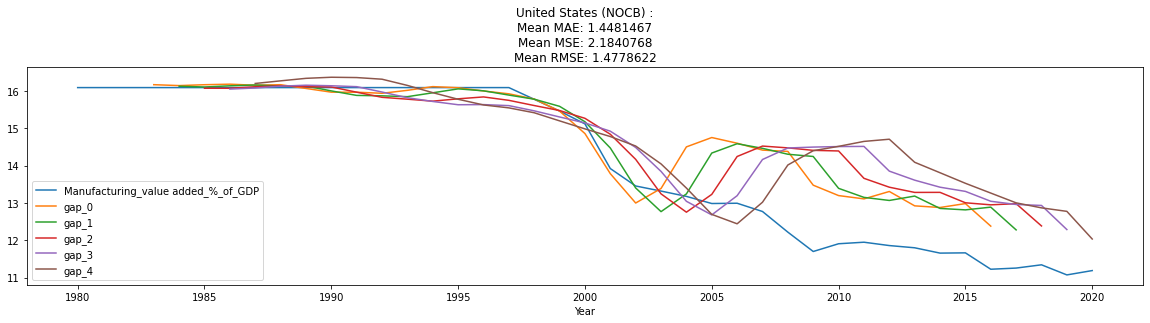

In [ ]:
for sheet in get_sheet_by_methods(Data_dic_m, 3):
  country = sheet[:3]
  method = sheet[3:].strip()
  print(dic_country[country], method, ':')
  try:
    a1, s1, r1 = pipeline(country, method)
    c.append(country)
    m.append(method)
    a.append(a1)
    s.append(s1)
    r.append(r1)
    print('\n')
  except:
    print(f'Cannot handle {country}, {method}')

###### Rolling Stats

Australia Rolling statistics :
Total Modelling Time:  13.943646430969238
1/1 [==============================] - 2s 2s/step
MAE [1.9057705, 1.8524315, 1.7159998, 1.4081757, 1.0845308]  Mean MAE 1.5933816 
MSE [3.9058738, 3.7266884, 3.3185012, 2.4550393, 1.7424647]  Mean MSE 3.0297134 
RMSE [1.9763284, 1.9304633, 1.8216754, 1.5668565, 1.3200245] Mean RMSE 1.7406071
1/1 [==============================] - 0s 75ms/step


1/1 [==============================] - 1s 1s/step


AUS_Rolling statistics
2022               12.416123
2023               12.329144
2024               12.454318
2025               12.669749
2026               12.824744



Brazil Rolling statistics :
Total Modelling Time:  15.26203441619873
1/1 [==============================] - 1s 1s/step
MAE [2.326785, 2.6337554, 3.1926644, 3.6190388, 4.14476]  Mean MAE 3.1834006 
MSE [5.934467, 7.6811004, 11.767394, 15.169952, 20.052042]  Mean MSE 12.120992 
RMSE [2.4360762, 2.7714798, 3.4303637, 3.8948624, 4.4779506] Mean RMSE 3.4815214
2/2 [==============================] - 0s 15ms/step


1/1 [==============================] - 1s 1s/step


BRA_Rolling statistics
2022               10.536184
2023               10.739278
2024               11.566303
2025               12.217006
2026               13.170922



India Rolling statistics :
Total Modelling Time:  14.899504661560059
1/1 [==============================] - 1s 1s/step
MAE [2.2085788, 2.1947963, 2.0327399, 1.9982443, 1.8480163]  Mean MAE 2.0564752 
MSE [4.886334, 4.8238897, 4.142905, 4.0051394, 3.435549]  Mean MSE 4.2587633 
RMSE [2.2105052, 2.1963356, 2.0354128, 2.0012844, 1.8535234] Mean RMSE 2.063677
1/1 [==============================] - 0s 77ms/step


1/1 [==============================] - 1s 1s/step


CAN_Rolling statistics
2022               12.941840
2023               13.116131
2024               13.302515
2025               13.566422
2026               13.634955



China Rolling statistics :
Total Modelling Time:  16.28457498550415
1/1 [==============================] - 1s 1s/step
MAE [1.4169483, 1.7752953, 1.9524155, 2.307008, 2.4966133]  Mean MAE 1.9896561 
MSE [2.1287198, 3.2495816, 3.9584112, 5.4808445, 6.3090835]  Mean MSE 4.2253284 
RMSE [1.4590133, 1.8026596, 1.9895756, 2.3411202, 2.5117888] Mean RMSE 2.0555604
1/1 [==============================] - 0s 59ms/step


1/1 [==============================] - 1s 1s/step


CHN_Rolling statistics
2022               31.820934
2023               31.849281
2024               31.810579
2025               31.692297
2026               31.615492



United Kingdom Rolling statistics :
Total Modelling Time:  14.967114925384521
1/1 [==============================] - 1s 1s/step
MAE [1.6383759, 1.5786669, 1.7269447, 1.3958206, 1.5788352]  Mean MAE 1.5837287 
MSE [3.4651103, 3.0825875, 3.7198627, 2.4307237, 3.001604]  Mean MSE 3.139978 
RMSE [1.8614807, 1.7557299, 1.9286946, 1.5590779, 1.7325138] Mean RMSE 1.7719983
1/1 [==============================] - 0s 72ms/step


1/1 [==============================] - 1s 1s/step


GBR_Rolling statistics
2022               16.105026
2023               15.974991
2024               16.098080
2025               15.869415
2026               16.081213



India Rolling statistics :
Total Modelling Time:  14.952383518218994
1/1 [==============================] - 2s 2s/step
MAE [0.3212471, 0.2680696, 0.21344025, 0.38949442, 0.9138527]  Mean MAE 0.4212208 
MSE [0.145071, 0.09650821, 0.073080905, 0.27374005, 0.98754555]  Mean MSE 0.31518918 
RMSE [0.38088188, 0.3106577, 0.2703348, 0.5232017, 0.99375325] Mean RMSE 0.5614171
2/2 [==============================] - 0s 15ms/step


1/1 [==============================] - 1s 1s/step


IND_Rolling statistics
2022               15.850539
2023               15.772868
2024               15.805717
2025               15.913938
2026               16.154152



Japan Rolling statistics :
Total Modelling Time:  14.119481086730957
1/1 [==============================] - 1s 1s/step
MAE [1.2958002, 1.1560321, 0.9977379, 0.8354759, 0.869617]  Mean MAE 1.0309327 
MSE [1.679838, 1.3865318, 1.1183338, 1.0031843, 0.9252726]  Mean MSE 1.2226322 
RMSE [1.2960856, 1.1775109, 1.057513, 1.0015908, 0.9619109] Mean RMSE 1.105727
1/1 [==============================] - 0s 65ms/step


1/1 [==============================] - 1s 1s/step


JPN_Rolling statistics
2022               21.773197
2023               22.070917
2024               22.115599
2025               22.255455
2026               22.204355



Singapore Rolling statistics :
Total Modelling Time:  16.01079249382019
1/1 [==============================] - 1s 1s/step
MAE [3.5147383, 4.1545215, 4.700597, 4.737306, 4.4622188]  Mean MAE 4.3138757 
MSE [12.769626, 17.476393, 22.211897, 22.506582, 19.926027]  Mean MSE 18.978106 
RMSE [3.5734613, 4.1804776, 4.7129498, 4.74411, 4.463858] Mean RMSE 4.3563867
2/2 [==============================] - 0s 16ms/step


1/1 [==============================] - 1s 1s/step


SGP_Rolling statistics
2022               23.599951
2023               23.903664
2024               24.325998
2025               24.514503
2026               24.456455



United States Rolling statistics :
Total Modelling Time:  14.653964757919312
1/1 [==============================] - 1s 1s/step
MAE [0.69838953, 0.6765282, 0.7377527, 0.7869389, 0.744092]  Mean MAE 0.7287403 
MSE [0.5040126, 0.47935295, 0.564283, 0.638605, 0.5677388]  Mean MSE 0.5507984 
RMSE [0.70993847, 0.6923532, 0.75118774, 0.79912764, 0.7534844] Mean RMSE 0.74215794
1/1 [==============================] - 0s 64ms/step


1/1 [==============================] - 1s 1s/step


USA_Rolling statistics
2022               12.943719
2023               12.972751
2024               12.980660
2025               12.979587
2026               12.966624

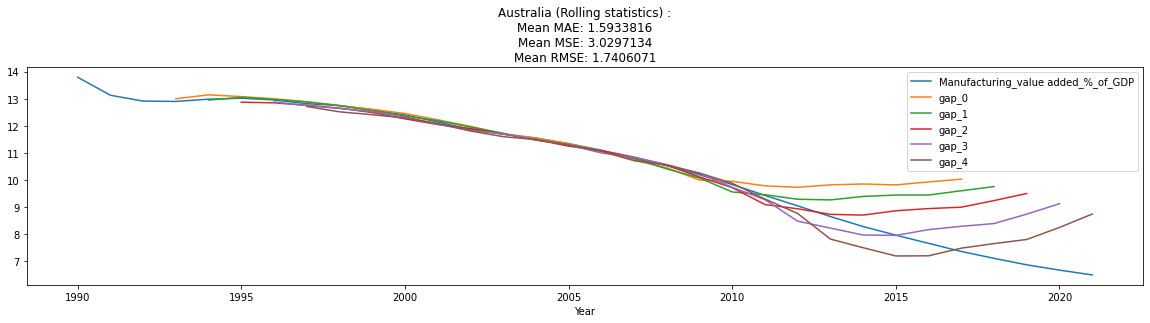

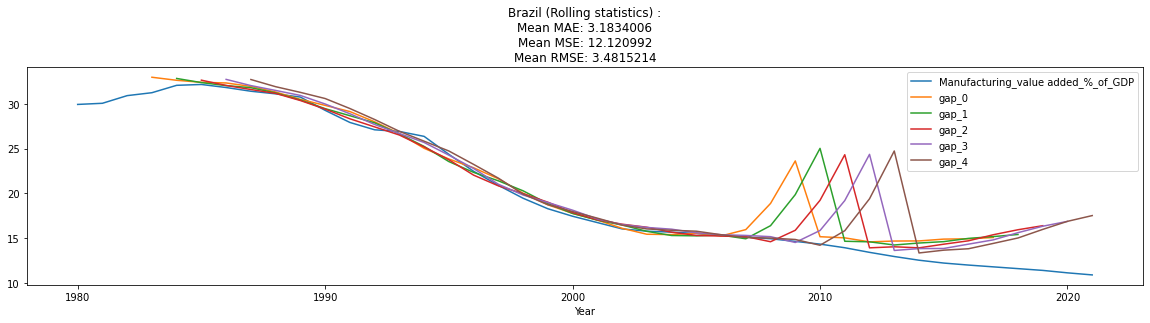

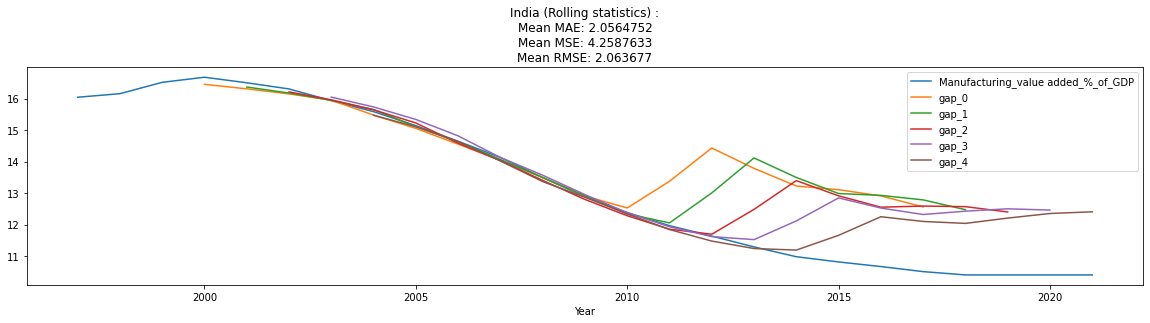

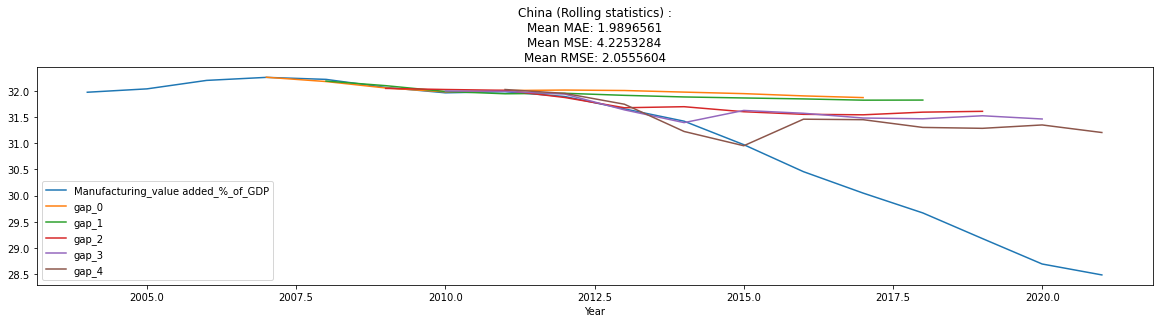

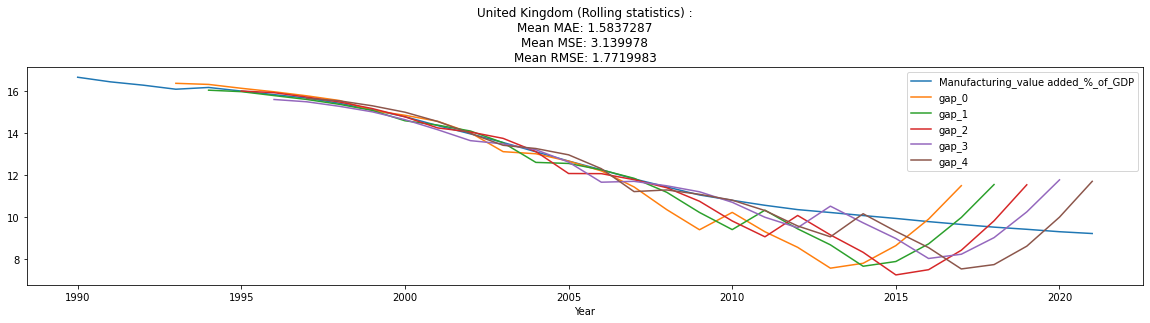

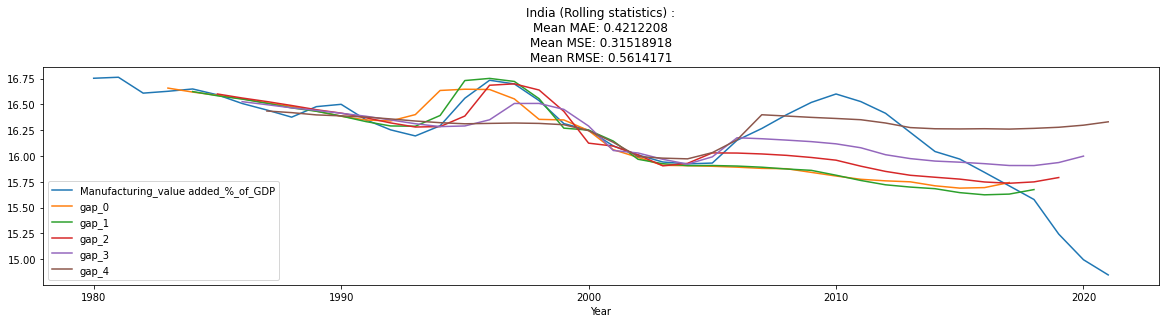

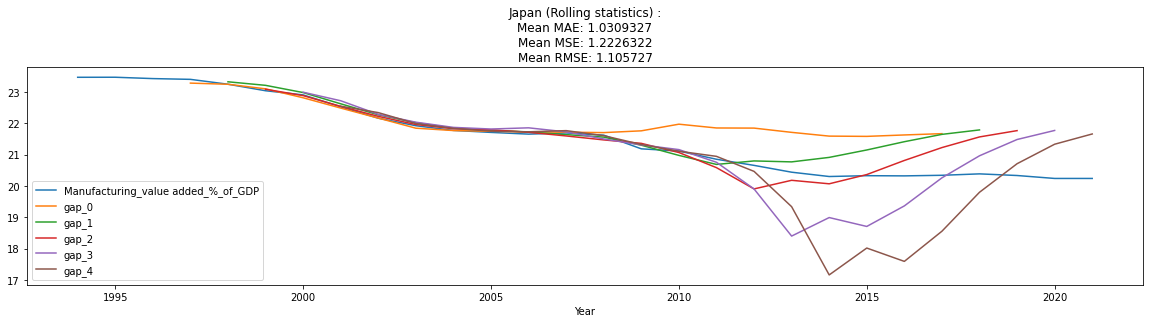

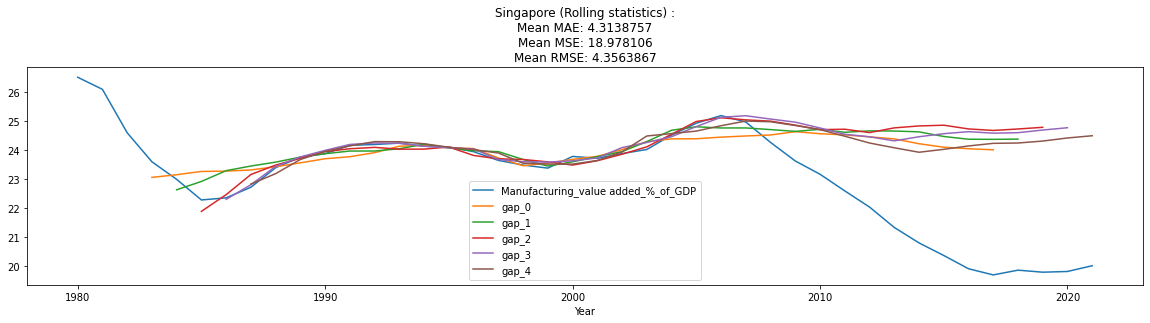

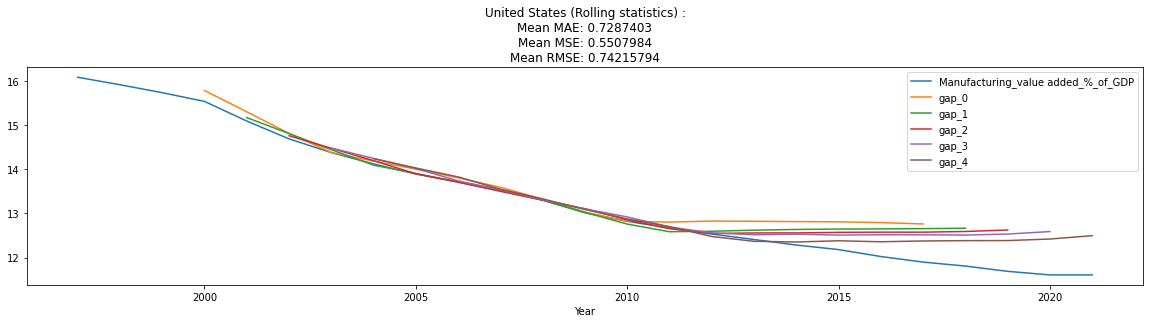

In [ ]:
for sheet in get_sheet_by_methods(Data_dic_m, 4):
  country = sheet[:3]
  method = sheet[3:].strip()
  print(dic_country[country], method, ':')
  try:
    a1, s1, r1 = pipeline(country, method)
    c.append(country)
    m.append(method)
    a.append(a1)
    s.append(s1)
    r.append(r1)
    print('\n')
  except:
    print(f'Cannot handle {country}, {method}')

###### Interpolate

In [ ]:
for sheet in get_sheet_by_methods(Data_dic_m, 5):
  country = sheet[:3]
  method = sheet[3:].strip()
  print(dic_country[country], method, ':')
  try:
    a1, s1, r1 = pipeline(country, method)
    c.append(country)
    m.append(method)
    a.append(a1)
    s.append(s1)
    r.append(r1)
    print('\n')
  except:
    print(f'Cannot handle {country}, {method}')

Australia Interpolate :
Cannot handle AUS, Interpolate
Brazil Interpolate :
Cannot handle BRA, Interpolate
India Interpolate :
Cannot handle CAN, Interpolate
China Interpolate :
Cannot handle CHN, Interpolate
United Kingdom Interpolate :
Cannot handle GBR, Interpolate
India Interpolate :
Cannot handle IND, Interpolate
Japan Interpolate :
Cannot handle JPN, Interpolate
Singapore Interpolate :
Cannot handle SGP, Interpolate
United States Interpolate :
Cannot handle USA, Interpolate


###### Summary

In [ ]:
pd.DataFrame({
    'country': c,
    'method': m,
    'MAE': a,
    'MSE': s,
    'RMSE': r
})

country              method        MAE         MSE       RMSE
0      AUS                Mean   5.117918   28.203815   5.310727
1      BRA                Mean  11.556614  137.236664  11.714806
2      CAN                Mean   1.646575    3.892528   1.972949
3      CHN                Mean   1.823219    4.084865   2.021105
4      GBR                Mean   3.600909   21.692493   4.657520
5      IND                Mean   1.411169    3.517263   1.875437
6      JPN                Mean   1.381026    2.229085   1.493012
7      SGP                Mean   3.105672   11.800231   3.435146
8      USA                Mean   0.662433    0.510167   0.714259
9      AUS              Median   4.141479   17.839935   4.223735
10     BRA              Median   5.557818   36.607079   6.050378
11     CAN              Median   1.423236    2.759808   1.661267
12     CHN              Median   2.592984    8.042283   2.835892
13     GBR              Median   2.186018   10.326080   3.213422
14     IND              Median   1.161588    2.434969   1.560439
15     JPN              Median   1.170521    1.651621   1.285154
16     SGP              Median   3.754099   16.078957   4.009858
17     USA              Median   0.613417    0.755886   0.869417
18     AUS                LOCF   2.419284    6.404049   2.530622
19     BRA                LOCF  16.245764  282.391235  16.804501
20     CAN                LOCF   0.305396    0.144096   0.379600
21     CHN                LOCF   2.781632    8.795014   2.965639
22     GBR                LOCF   0.634980    0.737475   0.858763
23     IND                LOCF   1.266327    2.587642   1.608615
24     JPN                LOCF   0.972568    1.355443   1.164235
25     SGP                LOCF   3.848386   16.400202   4.049716
26     USA                LOCF   0.582733    0.364206   0.603495
27     AUS                NOCB   3.117077   11.334241   3.366637
28     BRA                NOCB  13.045335  181.014587  13.454166
29     CAN                NOCB   6.268644   43.135796   6.567785
30     CHN                NOCB   4.387428   22.290770   4.721310
31     GBR                NOCB   6.226626   43.465561   6.592842
32     IND                NOCB   2.723374   11.625017   3.409548
33     JPN                NOCB   2.290857    5.686197   2.384575
34     SGP                NOCB   5.620948   34.802616   5.899374
35     USA                NOCB   1.448147    2.184077   1.477862
36     AUS  Rolling statistics   1.593382    3.029713   1.740607
37     BRA  Rolling statistics   3.183401   12.120992   3.481521
38     CAN  Rolling statistics   2.056475    4.258763   2.063677
39     CHN  Rolling statistics   1.989656    4.225328   2.055560
40     GBR  Rolling statistics   1.583729    3.139978   1.771998
41     IND  Rolling statistics   0.421221    0.315189   0.561417
42     JPN  Rolling statistics   1.030933    1.222632   1.105727
43     SGP  Rolling statistics   4.313876   18.978106   4.356387
44     USA  Rolling statistics   0.728740    0.550798   0.742158

##### Service

In [ ]:
c, m, a, s, r = [], [], [], [], []

###### Mean

Australia Mean :
Total Modelling Time:  15.024804830551147
1/1 [==============================] - 1s 1s/step
MAE [3.1088288, 3.3915832, 3.5235393, 3.8164985, 4.456031]  Mean MAE 3.6592968 
MSE [11.983944, 14.087582, 15.445359, 16.557695, 20.352476]  Mean MSE 15.6854105 
RMSE [3.4617834, 3.7533426, 3.9300585, 4.0691147, 4.511372] Mean RMSE 3.9604812
2/2 [==============================] - 0s 13ms/step


1/1 [==============================] - 1s 1s/step


AUS_Mean
2022  2.508459
2023  1.533389
2024  0.981249
2025  0.523124
2026  3.198630



Brazil Mean :
Total Modelling Time:  15.114820003509521
1/1 [==============================] - 1s 1s/step
MAE [6.6945763, 4.573434, 6.7760186, 7.632538, 6.535721]  Mean MAE 6.4424567 
MSE [48.993195, 28.526855, 53.501446, 66.18582, 49.191162]  Mean MSE 49.279697 
RMSE [6.999514, 5.341054, 7.3144684, 8.135467, 7.0136414] Mean RMSE 7.01995
2/2 [==============================] - 0s 15ms/step


1/1 [==============================] - 1s 1s/step


BRA_Mean
2022   7.117410
2023   7.855266
2024   8.660546
2025   9.273325
2026  10.988414



India Mean :
Total Modelling Time:  15.335373878479004
1/1 [==============================] - 2s 2s/step
MAE [1.832395, 1.4548548, 0.57777244, 1.1738569, 2.070175]  Mean MAE 1.4218109 
MSE [4.3349886, 2.6469753, 0.4665083, 1.7685076, 6.937899]  Mean MSE 3.230976 
RMSE [2.0820634, 1.6269528, 0.68301415, 1.3298525, 2.633989] Mean RMSE 1.7974917
2/2 [==============================] - 0s 22ms/step


1/1 [==============================] - 2s 2s/step


CAN_Mean
2022  14.343334
2023  16.446079
2024  20.220135
2025  23.207542
2026  24.113449



China Mean :
Total Modelling Time:  17.296425580978394
1/1 [==============================] - 1s 1s/step
MAE [1.2303368, 1.2262093, 1.7143831, 2.323478, 2.3479455]  Mean MAE 1.7684706 
MSE [1.9684992, 2.1381848, 3.572088, 5.6862965, 5.714861]  Mean MSE 3.8159862 
RMSE [1.4030322, 1.4622533, 1.8899968, 2.3845956, 2.3905776] Mean RMSE 1.953455
2/2 [==============================] - 0s 13ms/step


1/1 [==============================] - 1s 1s/step


CHN_Mean
2022  30.134357
2023  29.767235
2024  29.375051
2025  28.985674
2026  28.409691



United Kingdom Mean :
Total Modelling Time:  17.14159846305847
1/1 [==============================] - 1s 1s/step
MAE [2.6495624, 3.026746, 3.4595776, 3.5855052, 3.7783623]  Mean MAE 3.2999506 
MSE [13.475188, 17.881708, 18.673994, 17.22272, 18.363317]  Mean MSE 17.123386 
RMSE [3.6708567, 4.228677, 4.3213415, 4.1500263, 4.285244] Mean RMSE 4.1380415
2/2 [==============================] - 0s 14ms/step


1/1 [==============================] - 1s 1s/step


GBR_Mean
2022  12.980089
2023  12.999866
2024  12.458664
2025  12.251865
2026  12.361226



India Mean :
Total Modelling Time:  18.46833062171936
1/1 [==============================] - 1s 1s/step
MAE [0.4830486, 0.4369084, 1.3190366, 1.8961903, 2.3487554]  Mean MAE 1.2967879 
MSE [0.32811582, 0.33455148, 2.6205676, 4.977124, 6.443648]  Mean MSE 2.9408014 
RMSE [0.5728139, 0.57840425, 1.6188167, 2.230947, 2.538434] Mean RMSE 1.7148765
2/2 [==============================] - 0s 13ms/step


1/1 [==============================] - 1s 1s/step


IND_Mean
2022  15.640554
2023  15.600400
2024  15.675911
2025  15.596634
2026  15.772338



Japan Mean :
Total Modelling Time:  14.628765106201172
1/1 [==============================] - 1s 1s/step
MAE [1.3585056, 1.7030582, 1.6573118, 1.5757875, 1.2095762]  Mean MAE 1.500848 
MSE [2.5055354, 3.3067513, 2.94934, 2.5548403, 1.8398026]  Mean MSE 2.6312547 
RMSE [1.5828882, 1.8184475, 1.7173643, 1.5983868, 1.3563932] Mean RMSE 1.6221143
2/2 [==============================] - 0s 14ms/step


1/1 [==============================] - 1s 1s/step


JPN_Mean
2022  19.728647
2023  20.051729
2024  20.472738
2025  20.670826
2026  20.341665



Singapore Mean :
Total Modelling Time:  15.493168354034424
1/1 [==============================] - 1s 1s/step
MAE [3.4074717, 3.1157491, 2.856683, 2.8057582, 2.2059548]  Mean MAE 2.8783233 
MSE [12.077958, 12.104756, 10.091986, 9.087735, 5.750641]  Mean MSE 9.822615 
RMSE [3.4753356, 3.479189, 3.1767886, 3.0145872, 2.3980494] Mean RMSE 3.134105
2/2 [==============================] - 0s 16ms/step


1/1 [==============================] - 1s 1s/step


SGP_Mean
2022  18.771570
2023  18.921879
2024  19.398520
2025  20.688280
2026  22.014427



United States Mean :
Total Modelling Time:  16.8219895362854
1/1 [==============================] - 1s 1s/step
MAE [0.46105924, 0.8620839, 0.6001784, 0.25074354, 0.51031953]  Mean MAE 0.5368769 
MSE [0.27597857, 0.77782863, 0.40845433, 0.10446816, 0.5715793]  Mean MSE 0.42766178 
RMSE [0.5253366, 0.8819459, 0.6391043, 0.32321534, 0.7560286] Mean RMSE 0.65395856
2/2 [==============================] - 0s 15ms/step


1/1 [==============================] - 1s 1s/step


USA_Mean
2022  10.751804
2023  11.565133
2024  14.792904
2025  18.084005
2026  18.717716

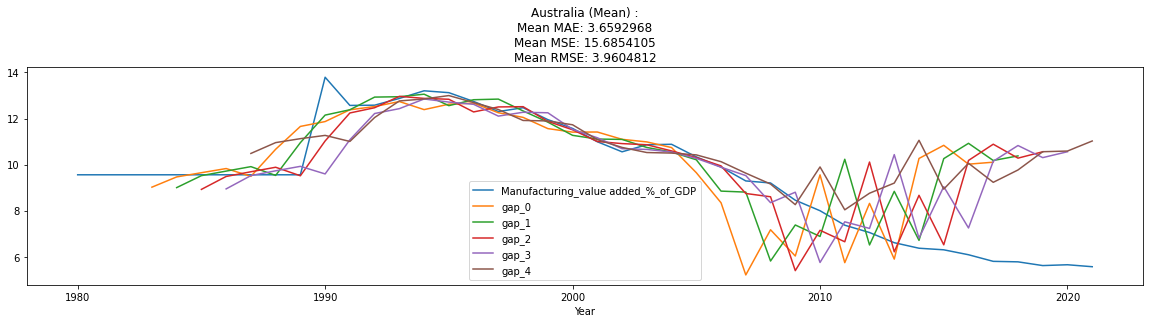

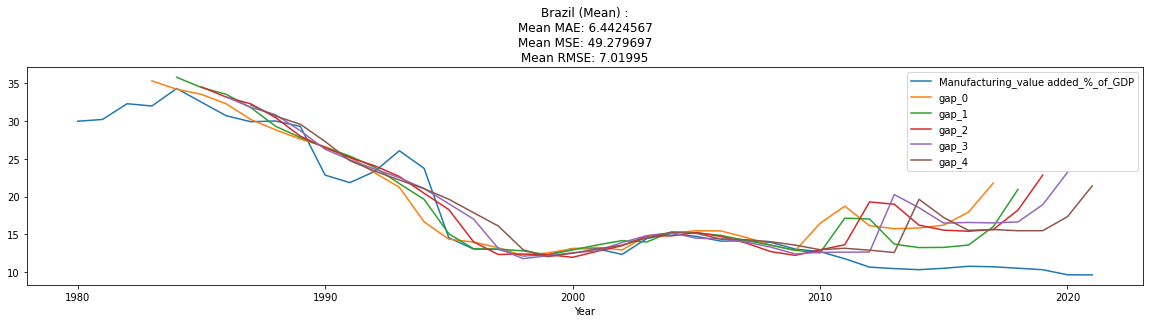

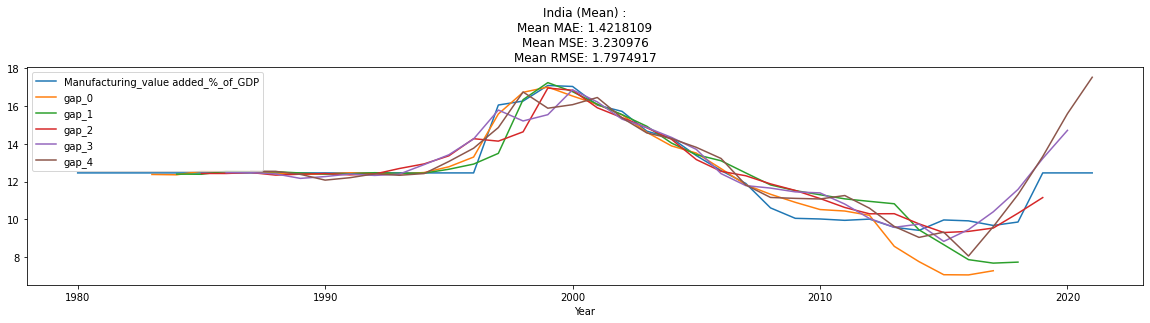

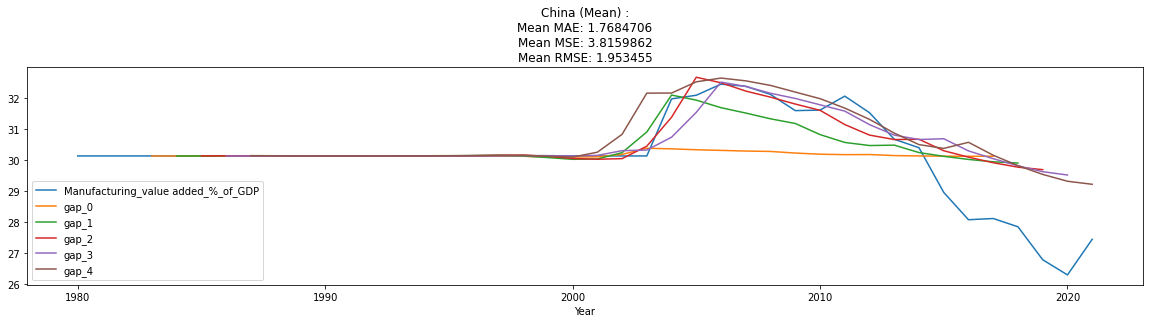

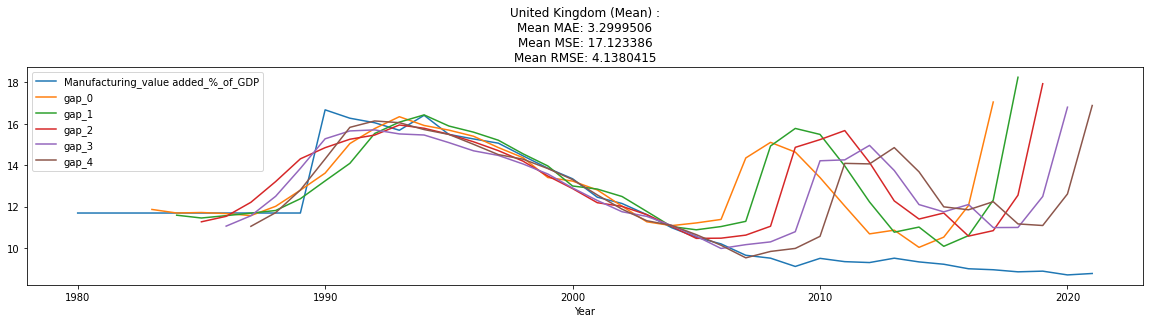

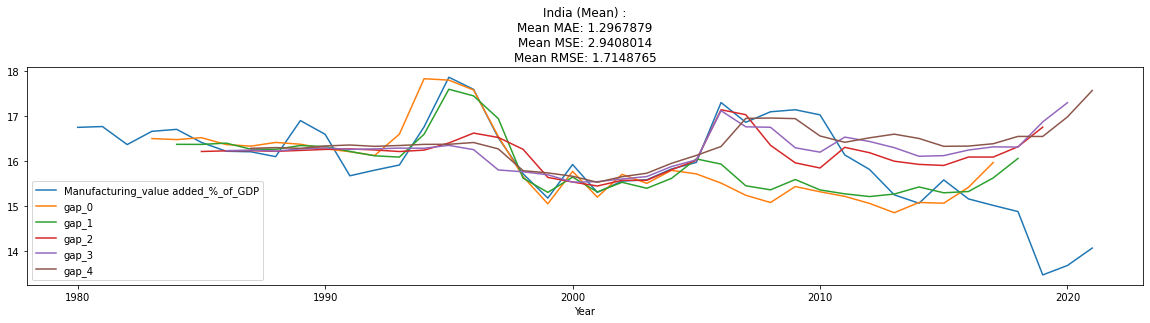

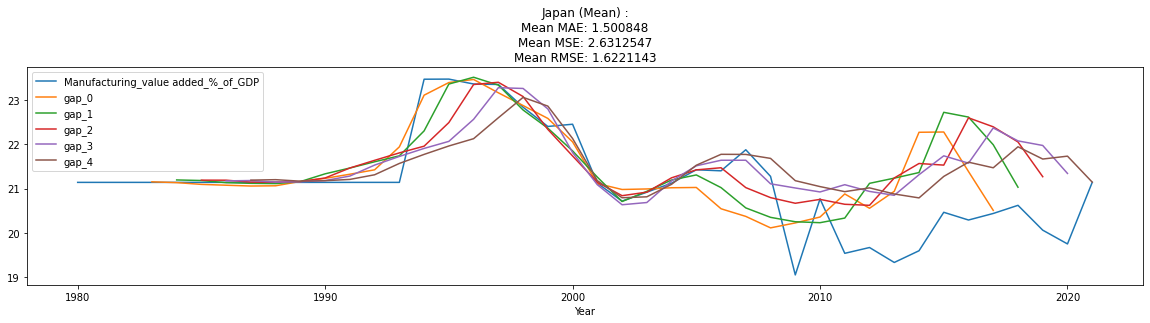

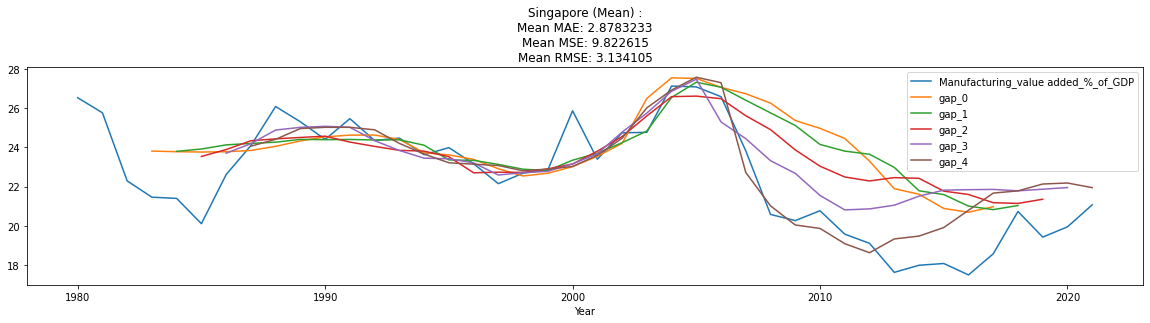

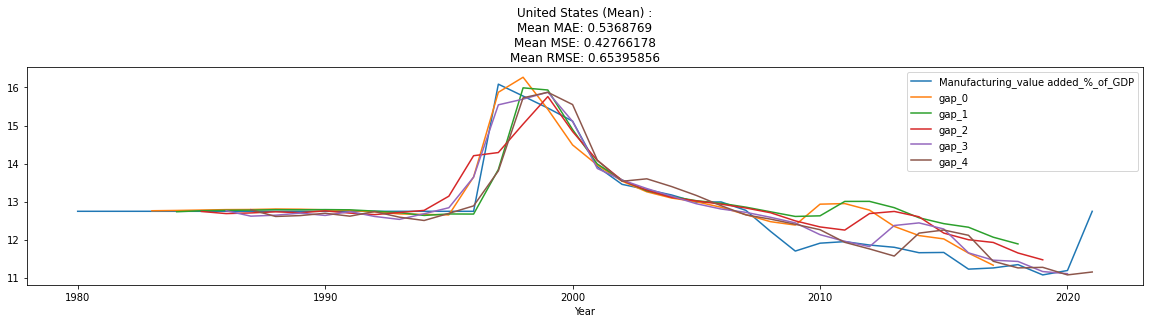

In [ ]:
for sheet in get_sheet_by_methods(Data_dic_s, 0):
  country = sheet[:3]
  method = sheet[3:].strip()
  print(dic_country[country], method, ':')
  a1, s1, r1 = pipeline(country, method)
  c.append(country)
  m.append(method)
  a.append(a1)
  s.append(s1)
  r.append(r1)
  print('\n')

###### Median

Australia Median :
Total Modelling Time:  17.007603645324707
1/1 [==============================] - 1s 1s/step
MAE [4.63356, 5.385123, 5.79345, 6.2791295, 6.9717965]  Mean MAE 5.8126116 
MSE [21.760513, 29.761614, 34.75488, 40.6097, 51.182415]  Mean MSE 35.613823 
RMSE [4.6648164, 5.4554205, 5.895327, 6.372574, 7.1541886] Mean RMSE 5.967732
2/2 [==============================] - 0s 12ms/step


1/1 [==============================] - 1s 1s/step


AUS_Median
2022    9.261397
2023    9.038344
2024    8.703796
2025    9.020734
2026    8.992463



Brazil Median :
Total Modelling Time:  16.679579734802246
1/1 [==============================] - 2s 2s/step
MAE [20.180666, 18.69528, 16.259108, 13.5317335, 11.860251]  Mean MAE 16.10541 
MSE [409.07803, 353.5686, 271.8039, 194.99109, 153.87401]  Mean MSE 276.66312 
RMSE [20.225677, 18.80342, 16.486477, 13.963921, 12.404596] Mean RMSE 16.633194
2/2 [==============================] - 0s 23ms/step


1/1 [==============================] - 2s 2s/step


BRA_Median
2022    7.604426
2023    7.640927
2024    8.554424
2025    9.897858
2026   10.633428



India Median :
Total Modelling Time:  18.00056791305542
1/1 [==============================] - 1s 1s/step
MAE [1.8324037, 1.4779924, 1.1918501, 1.1375341, 1.430307]  Mean MAE 1.4140174 
MSE [3.8769844, 2.5895288, 1.8871402, 1.7329278, 2.7117157]  Mean MSE 2.5596592 
RMSE [1.969006, 1.6092013, 1.3737322, 1.3164072, 1.6467288] Mean RMSE 1.5998935
2/2 [==============================] - 0s 14ms/step


1/1 [==============================] - 2s 2s/step


CAN_Median
2022   13.778367
2023   15.937523
2024   17.187323
2025   18.311188
2026   19.639410



China Median :
Total Modelling Time:  15.715841293334961
1/1 [==============================] - 1s 1s/step
MAE [1.6204853, 2.0908172, 2.7028902, 3.377898, 3.5378401]  Mean MAE 2.665986 
MSE [3.934415, 5.460653, 8.159627, 11.858394, 12.800964]  Mean MSE 8.442811 
RMSE [1.983536, 2.336804, 2.856506, 3.4436018, 3.5778434] Mean RMSE 2.9056516
2/2 [==============================] - 0s 15ms/step


1/1 [==============================] - 1s 1s/step


CHN_Median
2022   31.100958
2023   30.934555
2024   30.646448
2025   30.519514
2026   30.370186



United Kingdom Median :
Total Modelling Time:  16.78417682647705
1/1 [==============================] - 1s 1s/step
MAE [1.5909519, 1.8563699, 2.088897, 2.365114, 2.5799491]  Mean MAE 2.0962563 
MSE [5.5942197, 7.4498944, 8.475301, 9.26393, 9.648911]  Mean MSE 8.086452 
RMSE [2.3652103, 2.7294495, 2.911237, 3.0436704, 3.1062696] Mean RMSE 2.8436687
2/2 [==============================] - 0s 13ms/step


1/1 [==============================] - 1s 1s/step


GBR_Median
2022   11.251521
2023   11.181160
2024   10.196696
2025   10.093850
2026   10.110117



India Median :
Total Modelling Time:  16.89184546470642
1/1 [==============================] - 1s 1s/step
MAE [0.3117725, 0.25949064, 1.419877, 1.5860935, 2.2072532]  Mean MAE 1.1568973 
MSE [0.16566862, 0.09562536, 2.682235, 3.250043, 5.3416686]  Mean MSE 2.3070483 
RMSE [0.40702412, 0.30923352, 1.637753, 1.8027875, 2.311205] Mean RMSE 1.518897
2/2 [==============================] - 0s 13ms/step


1/1 [==============================] - 1s 1s/step


IND_Median
2022   15.415114
2023   15.240507
2024   15.455797
2025   15.296416
2026   15.584467



Japan Median :
Total Modelling Time:  15.518016338348389
1/1 [==============================] - 1s 1s/step
MAE [1.4179379, 1.4919367, 1.3797531, 1.2186937, 1.0469621]  Mean MAE 1.3110565 
MSE [2.6599286, 2.7302973, 2.1925294, 1.562284, 1.2663816]  Mean MSE 2.082284 
RMSE [1.6309288, 1.6523612, 1.4807192, 1.2499136, 1.1253362] Mean RMSE 1.4430121
2/2 [==============================] - 0s 16ms/step


1/1 [==============================] - 2s 2s/step


JPN_Median
2022   19.504593
2023   19.610317
2024   19.884939
2025   19.705273
2026   19.584593



Singapore Median :
Total Modelling Time:  16.103306770324707
1/1 [==============================] - 1s 1s/step
MAE [4.599806, 4.2919755, 4.0214353, 3.5750227, 2.3714628]  Mean MAE 3.7719407 
MSE [21.467134, 20.727358, 18.038542, 13.834164, 6.5266166]  Mean MSE 16.118763 
RMSE [4.633264, 4.552731, 4.2471805, 3.7194304, 2.5547245] Mean RMSE 4.0148177
2/2 [==============================] - 0s 14ms/step


1/1 [==============================] - 1s 1s/step


SGP_Median
2022   19.482756
2023   19.612583
2024   19.687561
2025   20.749166
2026   22.624149



United States Median :
Total Modelling Time:  16.238896131515503
1/1 [==============================] - 1s 1s/step
MAE [0.15682428, 0.17461713, 0.21777122, 0.41673312, 0.82073116]  Mean MAE 0.3573354 
MSE [0.03842173, 0.047720876, 0.06777189, 0.28492498, 1.1470667]  Mean MSE 0.31718126 
RMSE [0.19601463, 0.21845108, 0.26033035, 0.5337837, 1.071012] Mean RMSE 0.5631885
2/2 [==============================] - 0s 18ms/step


1/1 [==============================] - 1s 1s/step


USA_Median
2022   10.577803
2023   12.319962
2024   13.509584
2025   14.217436
2026   15.427177

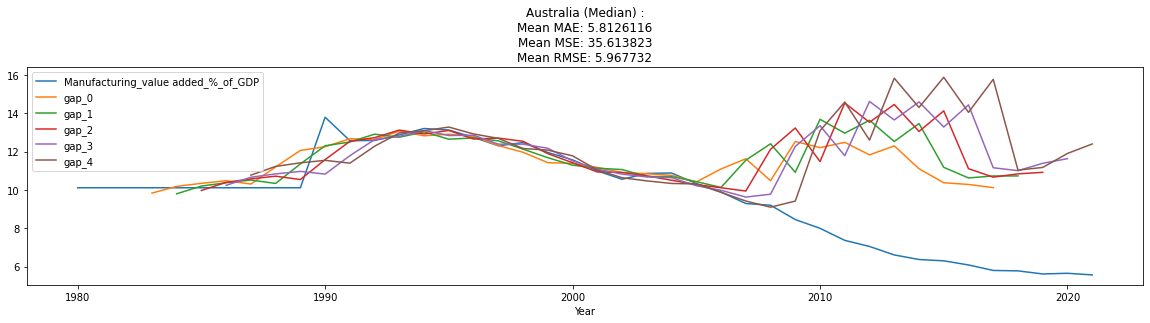

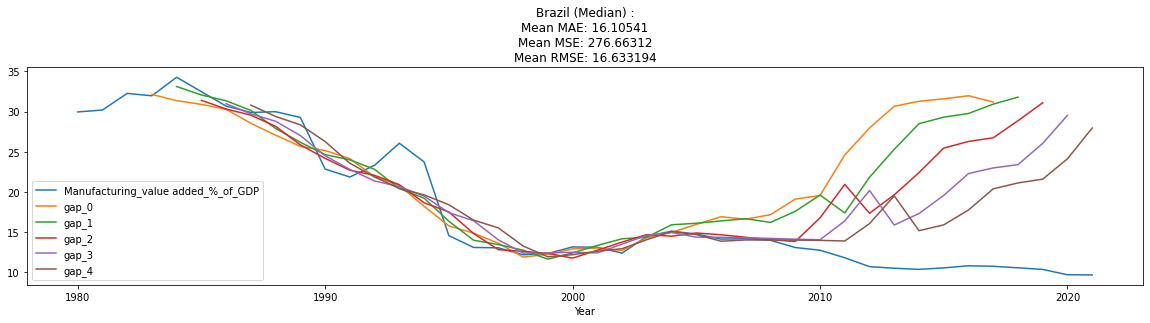

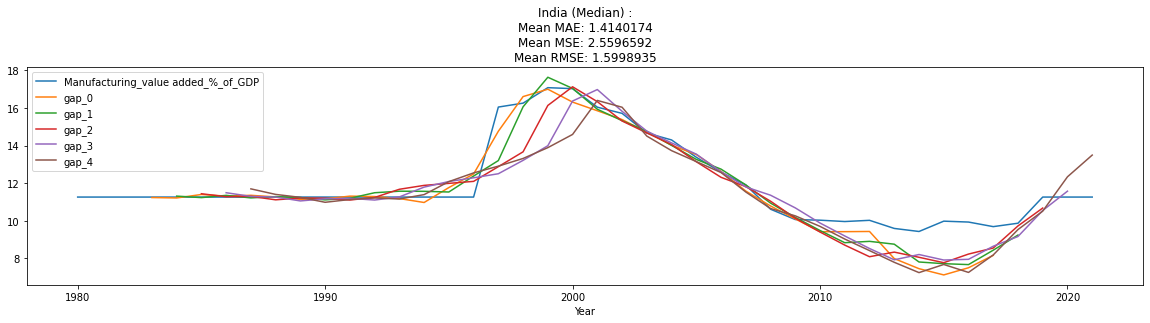

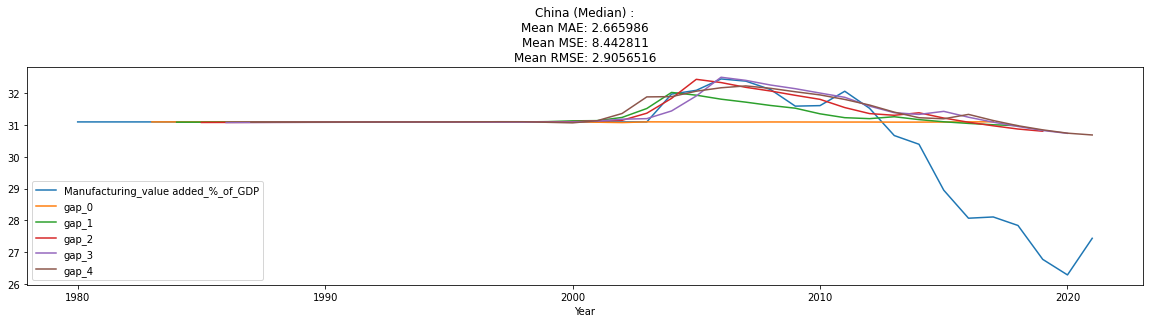

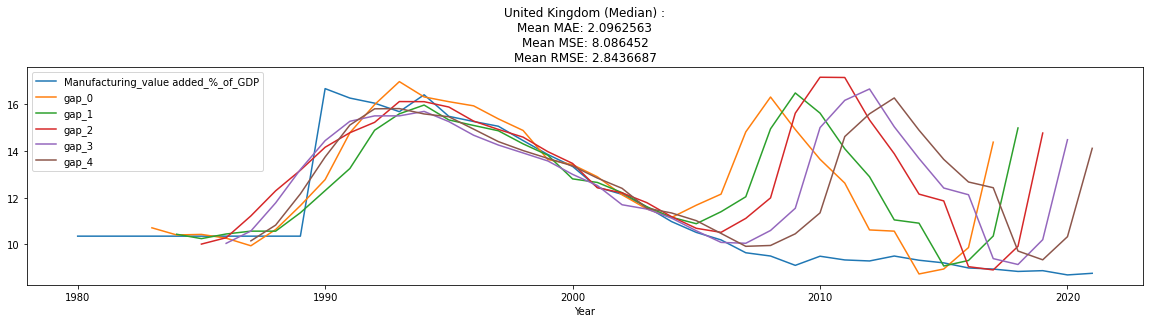

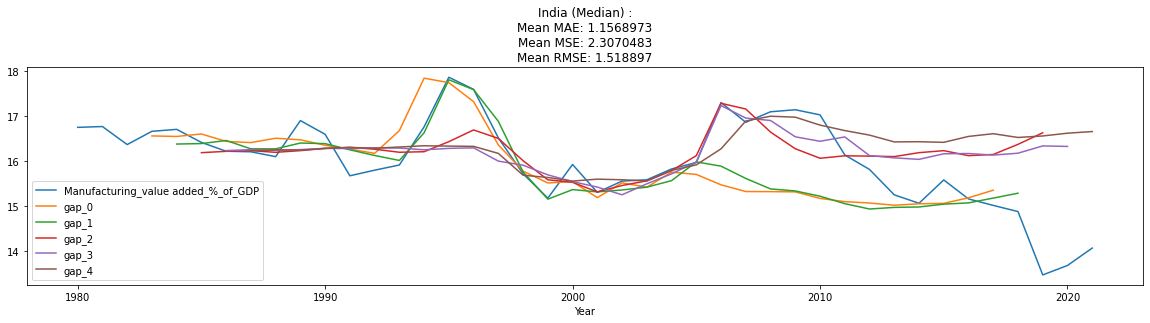

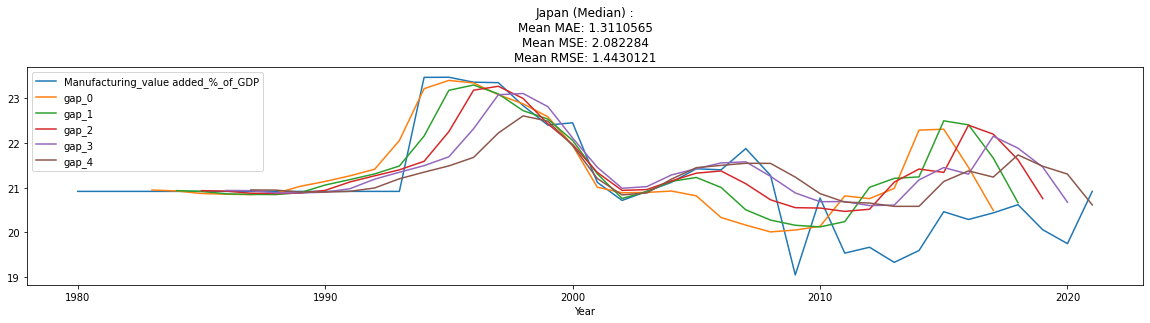

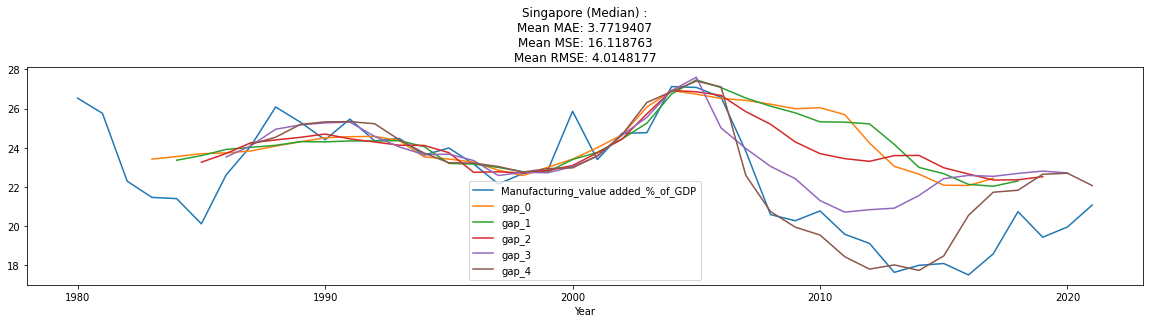

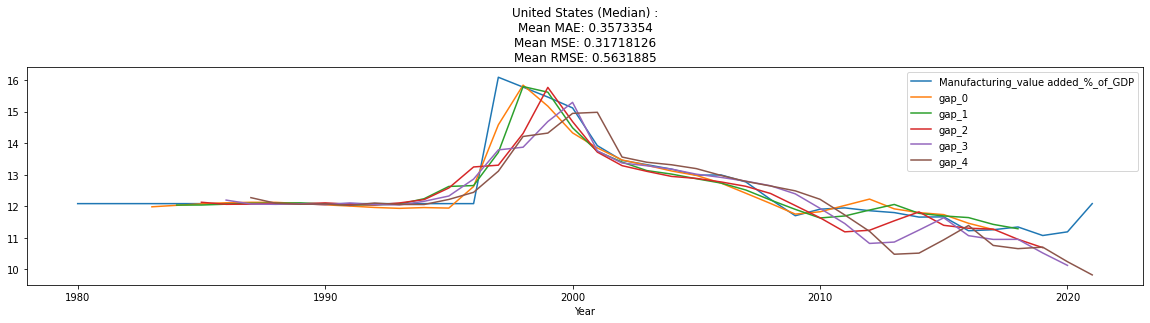

In [ ]:
for sheet in get_sheet_by_methods(Data_dic_s, 1):
  country = sheet[:3]
  method = sheet[3:].strip()
  print(dic_country[country], method, ':')
  try:
    a1, s1, r1 = pipeline(country, method)
    c.append(country)
    m.append(method)
    a.append(a1)
    s.append(s1)
    r.append(r1)
    print('\n')
  except:
    print(f'Cannot handle {country}, {method}')

###### LOCF

Australia LOCF :
Total Modelling Time:  15.407738208770752
1/1 [==============================] - 1s 1s/step
MAE [2.8634517, 2.7206926, 2.2510743, 2.3298702, 2.2048068]  Mean MAE 2.473979 
MSE [8.450157, 7.5908012, 5.747489, 6.0677643, 5.7193556]  Mean MSE 6.7151136 
RMSE [2.9069154, 2.7551408, 2.397392, 2.4632833, 2.3915174] Mean RMSE 2.5913537
1/1 [==============================] - 0s 71ms/step


1/1 [==============================] - 1s 1s/step


AUS_LOCF
2022  14.051686
2023  14.348681
2024  13.561419
2025  13.489102
2026  15.060602



Brazil LOCF :
Total Modelling Time:  16.217912912368774
1/1 [==============================] - 1s 1s/step
MAE [14.037829, 16.87691, 16.878273, 18.508953, 18.474909]  Mean MAE 16.955376 
MSE [201.3722, 293.0142, 293.45407, 357.0708, 359.0227]  Mean MSE 300.78677 
RMSE [14.190567, 17.117657, 17.1305, 18.896317, 18.947895] Mean RMSE 17.343204
2/2 [==============================] - 0s 15ms/step


1/1 [==============================] - 1s 1s/step


BRA_LOCF
2022  5.028304
2023  5.765244
2024  7.501431
2025  8.488283
2026  9.848727



India LOCF :
Total Modelling Time:  14.126562356948853
1/1 [==============================] - 1s 1s/step
MAE [0.38796473, 0.4393747, 0.27955508, 0.21934605, 0.20494509]  Mean MAE 0.30623713 
MSE [0.18425077, 0.27942312, 0.119426176, 0.075221285, 0.053253107]  Mean MSE 0.14231488 
RMSE [0.42924443, 0.52860487, 0.34558094, 0.274265, 0.23076634] Mean RMSE 0.37724644
1/1 [==============================] - 0s 59ms/step


1/1 [==============================] - 2s 2s/step


CAN_LOCF
2022  11.173980
2023  10.892646
2024  10.947060
2025  11.038173
2026  11.103416



China LOCF :
Total Modelling Time:  14.624068260192871
1/1 [==============================] - 1s 1s/step
MAE [3.696111, 3.4290676, 2.3993187, 2.6389835, 1.4029089]  Mean MAE 2.713278 
MSE [13.713323, 11.929307, 7.371494, 8.21149, 2.6509502]  Mean MSE 8.775313 
RMSE [3.7031503, 3.453883, 2.7150495, 2.8655696, 1.6281738] Mean RMSE 2.9623156
1/1 [==============================] - 0s 70ms/step


1/1 [==============================] - 1s 1s/step


CHN_LOCF
2022  31.161142
2023  31.408873
2024  31.218061
2025  31.088415
2026  31.493858



United Kingdom LOCF :
Total Modelling Time:  15.046951055526733
1/1 [==============================] - 1s 1s/step
MAE [0.3520773, 0.39608365, 0.38038808, 0.8470562, 0.8985699]  Mean MAE 0.574835 
MSE [0.20788698, 0.3531288, 0.32797772, 1.0612594, 1.0549996]  Mean MSE 0.6010505 
RMSE [0.45594624, 0.5942464, 0.5726934, 1.0301745, 1.0271317] Mean RMSE 0.77527446
1/1 [==============================] - 0s 78ms/step


1/1 [==============================] - 1s 1s/step


GBR_LOCF
2022  12.542252
2023  12.803400
2024  12.772367
2025  12.662702
2026  12.465518



India LOCF :
Total Modelling Time:  15.512388706207275
1/1 [==============================] - 1s 1s/step
MAE [0.8902629, 0.40237665, 0.75287837, 1.6986033, 2.406987]  Mean MAE 1.2302215 
MSE [0.8417995, 0.23418732, 1.1447979, 3.808631, 6.505014]  Mean MSE 2.5068858 
RMSE [0.9174963, 0.48392904, 1.0699522, 1.9515713, 2.5504928] Mean RMSE 1.5833148
2/2 [==============================] - 0s 18ms/step


1/1 [==============================] - 1s 1s/step


IND_LOCF
2022  15.660406
2023  15.870028
2024  15.821674
2025  15.601387
2026  15.810674



Japan LOCF :
Total Modelling Time:  13.266855955123901
1/1 [==============================] - 1s 1s/step
MAE [0.94510794, 0.9223261, 0.9557247, 1.0165639, 1.1718802]  Mean MAE 1.0023205 
MSE [1.6204754, 1.2579391, 1.2623485, 1.2926197, 1.820508]  Mean MSE 1.4507782 
RMSE [1.2729789, 1.1215788, 1.1235429, 1.1369344, 1.349262] Mean RMSE 1.2044826
1/1 [==============================] - 0s 72ms/step


1/1 [==============================] - 2s 2s/step


JPN_LOCF
2022  19.897432
2023  20.733288
2024  21.164145
2025  22.365078
2026  22.414835



Singapore LOCF :
Total Modelling Time:  15.96720027923584
1/1 [==============================] - 1s 1s/step
MAE [4.5817866, 3.991891, 3.9926822, 3.5332117, 2.6481907]  Mean MAE 3.7495527 
MSE [21.316217, 18.119835, 17.549118, 13.512845, 7.8572755]  Mean MSE 15.671058 
RMSE [4.616949, 4.25674, 4.1891665, 3.6759822, 2.8030832] Mean RMSE 3.9586687
2/2 [==============================] - 0s 18ms/step


1/1 [==============================] - 1s 1s/step


SGP_LOCF
2022  19.760067
2023  19.509766
2024  19.995213
2025  21.008486
2026  22.808107



United States LOCF :
Total Modelling Time:  14.577857971191406
1/1 [==============================] - 1s 1s/step
MAE [0.46452093, 0.39665484, 0.5427532, 0.59535503, 0.6975455]  Mean MAE 0.5393659 
MSE [0.2282548, 0.18148941, 0.3032262, 0.36738053, 0.49826074]  Mean MSE 0.31572235 
RMSE [0.4777602, 0.42601573, 0.5506598, 0.6061192, 0.7058759] Mean RMSE 0.56189173
1/1 [==============================] - 0s 57ms/step


1/1 [==============================] - 1s 1s/step


USA_LOCF
2022  11.765449
2023  11.643908
2024  11.639362
2025  11.770764
2026  11.887796

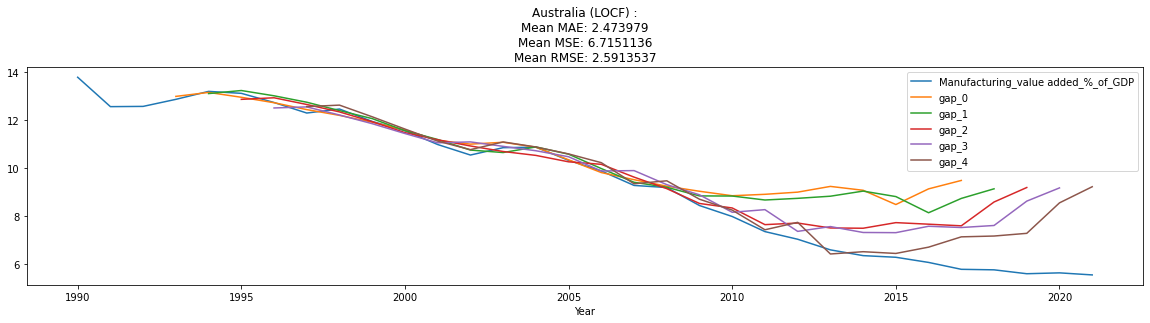

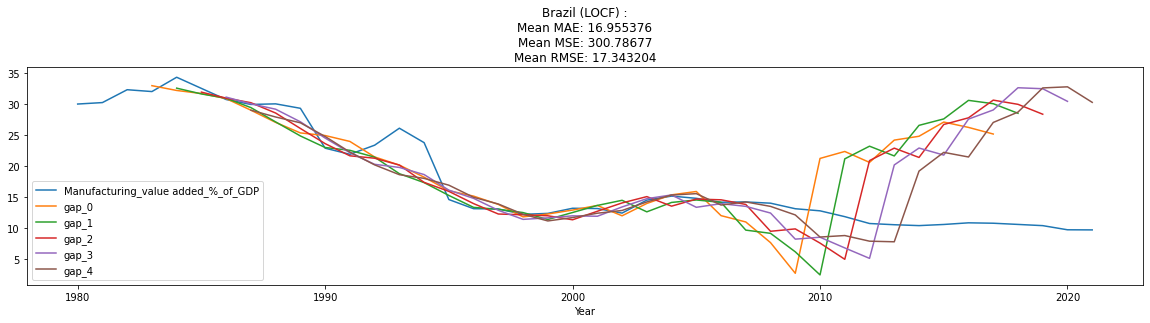

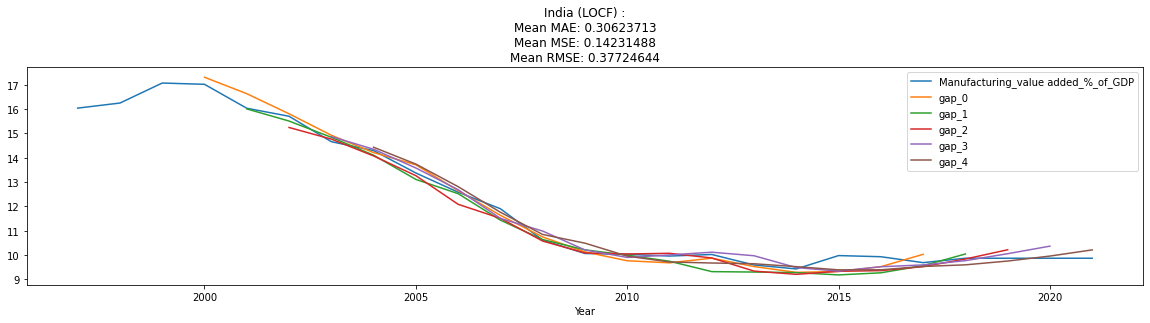

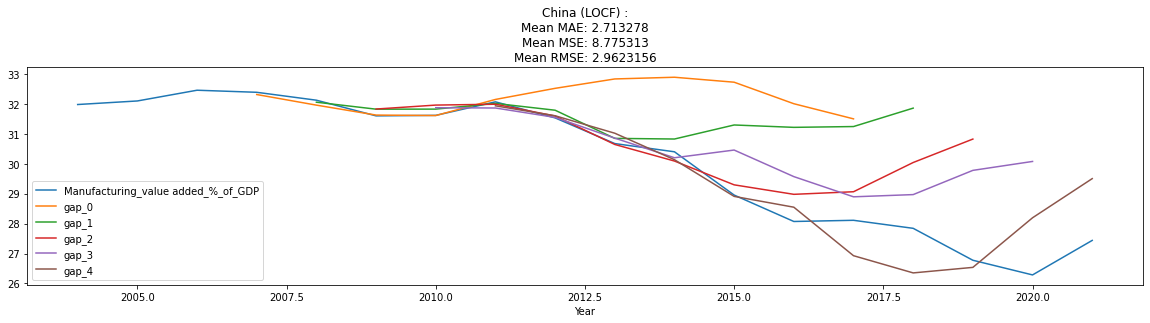

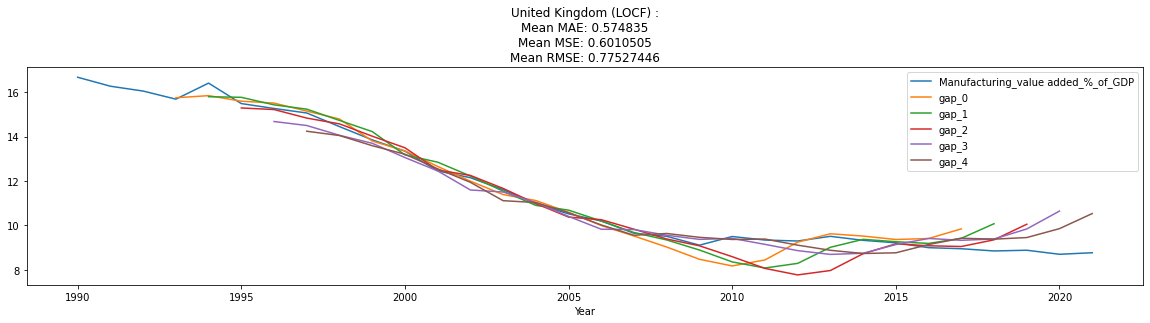

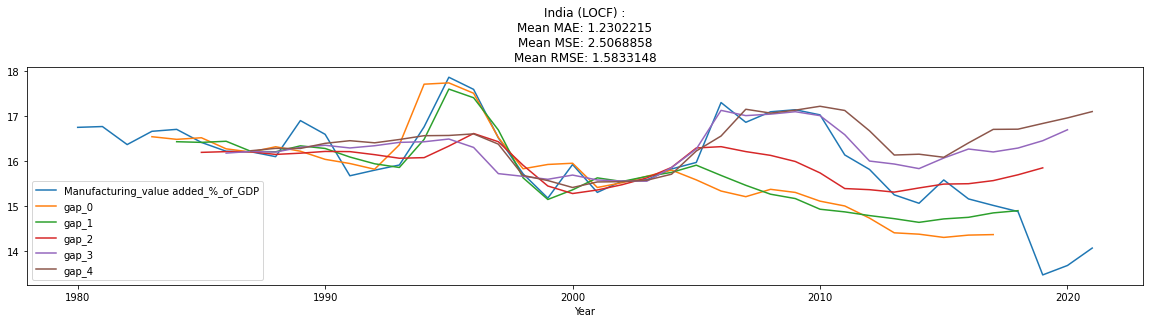

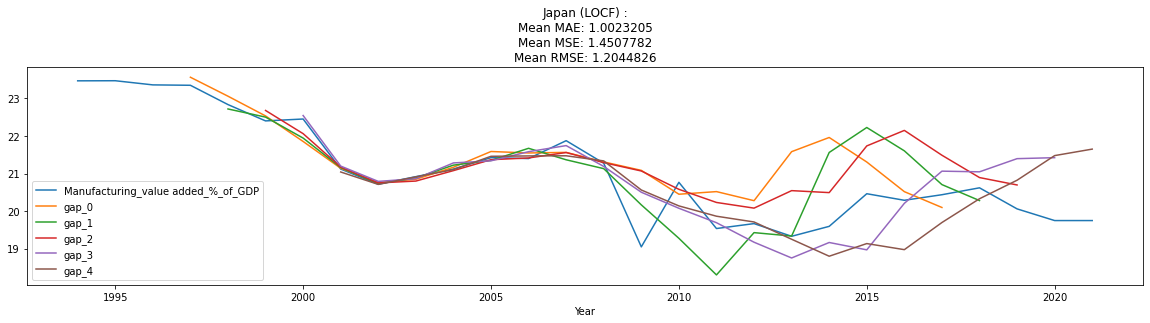

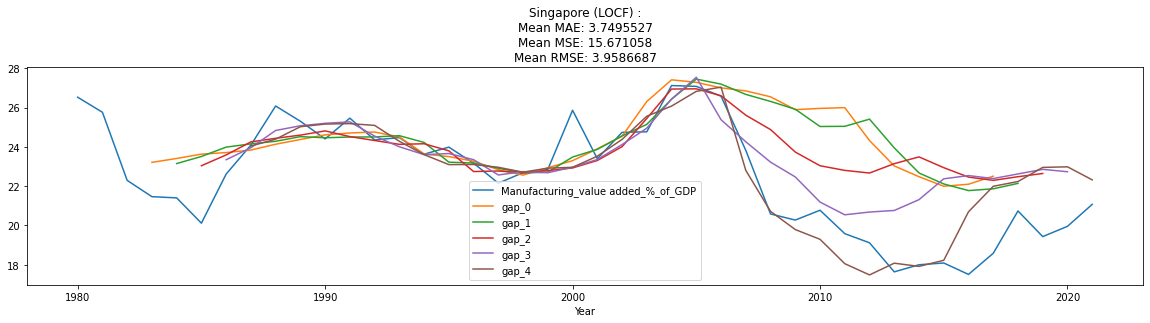

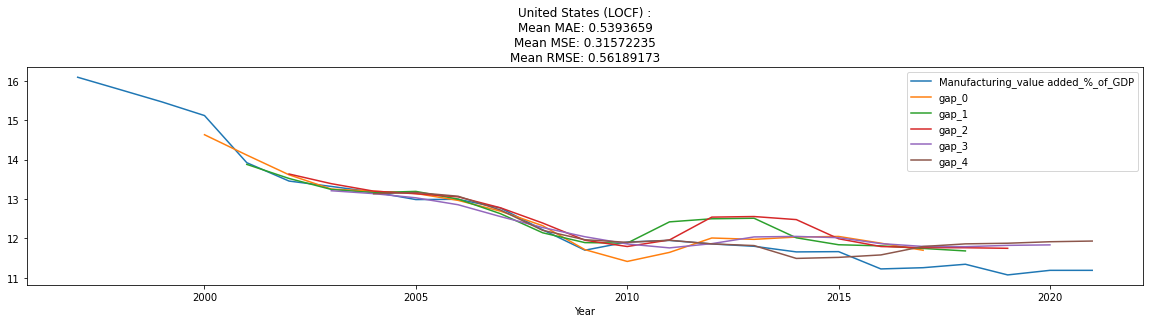

In [ ]:
for sheet in get_sheet_by_methods(Data_dic_s, 2):
  country = sheet[:3]
  method = sheet[3:].strip()
  print(dic_country[country], method, ':')
  try:
    a1, s1, r1 = pipeline(country, method)
    c.append(country)
    m.append(method)
    a.append(a1)
    s.append(s1)
    r.append(r1)
    print('\n')
  except:
    print(f'Cannot handle {country}, {method}')

###### NOCB

Australia NOCB :
Total Modelling Time:  17.257861137390137
1/1 [==============================] - 2s 2s/step
MAE [3.5491278, 3.7611265, 3.2705908, 2.658251, 2.4040825]  Mean MAE 3.128636 
MSE [12.736477, 14.238476, 11.3024645, 8.687184, 7.633186]  Mean MSE 10.919557 
RMSE [3.56882, 3.7733905, 3.361914, 2.947403, 2.7628222] Mean RMSE 3.3044753
2/2 [==============================] - 0s 15ms/step


1/1 [==============================] - 1s 1s/step


AUS_NOCB
2022  12.958809
2023  12.232180
2024   8.692937
2025   6.513332
2026   6.401117



Brazil NOCB :
Total Modelling Time:  17.124879360198975
1/1 [==============================] - 1s 1s/step
MAE [12.13618, 14.314641, 16.156404, 16.314135, 18.82799]  Mean MAE 15.549869 
MSE [151.81358, 211.81429, 270.48166, 277.10928, 373.0767]  Mean MSE 256.8591 
RMSE [12.321265, 14.553841, 16.446327, 16.646599, 19.315193] Mean RMSE 16.026825
2/2 [==============================] - 0s 13ms/step


1/1 [==============================] - 1s 1s/step


BRA_NOCB
2022   9.474215
2023   9.668484
2024   9.676369
2025  10.350307
2026  10.740898



India NOCB :
Total Modelling Time:  14.4651939868927
1/1 [==============================] - 1s 1s/step
MAE [5.3627133, 4.6810594, 5.2677355, 6.514815, 8.3922825]  Mean MAE 6.043721 
MSE [28.825077, 21.992651, 27.871084, 42.59693, 70.95677]  Mean MSE 38.4485 
RMSE [5.368899, 4.6896324, 5.2793074, 6.5266323, 8.423584] Mean RMSE 6.2006855
1/1 [==============================] - 0s 75ms/step


1/1 [==============================] - 2s 2s/step


CAN_NOCB
2019  15.911929
2020  15.594594
2021  15.687766
2022  16.023853
2023  16.665667



China NOCB :
Total Modelling Time:  14.687992095947266
1/1 [==============================] - 1s 1s/step
MAE [2.3938847, 3.0589914, 5.072435, 6.6630673, 6.1175637]  Mean MAE 4.6611886 
MSE [7.462559, 10.665096, 27.033373, 45.14479, 37.9979]  Mean MSE 25.66074 
RMSE [2.7317686, 3.2657459, 5.1993628, 6.7189875, 6.1642437] Mean RMSE 5.0656433
2/2 [==============================] - 0s 14ms/step


1/1 [==============================] - 1s 1s/step


CHN_NOCB
2022  31.988935
2023  32.017681
2024  32.693436
2025  33.145176
2026  32.756615



United Kingdom NOCB :
Total Modelling Time:  15.818378925323486
1/1 [==============================] - 1s 1s/step
MAE [2.7374032, 4.7397766, 7.138081, 5.8299108, 7.813829]  Mean MAE 5.6518006 
MSE [8.906172, 24.677864, 55.56381, 36.51923, 65.210045]  Mean MSE 38.175423 
RMSE [2.9843209, 4.967682, 7.4541135, 6.043114, 8.0752735] Mean RMSE 6.178626
2/2 [==============================] - 0s 15ms/step


1/1 [==============================] - 1s 1s/step


GBR_NOCB
2022  6.305672
2023  4.249115
2024  1.647081
2025  3.000779
2026  0.887289



India NOCB :
Total Modelling Time:  14.61696481704712
1/1 [==============================] - 1s 1s/step
MAE [0.7321871, 0.28529835, 2.5954466, 3.961666, 4.7440095]  Mean MAE 2.4637215 
MSE [0.58105224, 0.12195283, 8.203803, 17.69145, 24.101196]  Mean MSE 10.139892 
RMSE [0.7622678, 0.34921744, 2.8642282, 4.2061205, 4.909297] Mean RMSE 3.1843197
2/2 [==============================] - 0s 13ms/step


1/1 [==============================] - 1s 1s/step


IND_NOCB
2022  14.669785
2023  15.658084
2024  17.545742
2025  18.425226
2026  18.851196



Japan NOCB :
Total Modelling Time:  14.036867141723633
1/1 [==============================] - 1s 1s/step
MAE [2.1470397, 2.1591585, 2.2153313, 2.3673468, 2.7894602]  Mean MAE 2.3356671 
MSE [5.118162, 4.968009, 5.283474, 6.1021094, 8.345288]  Mean MSE 5.9634085 
RMSE [2.2623355, 2.228903, 2.298581, 2.470245, 2.8888214] Mean RMSE 2.4420092
2/2 [==============================] - 0s 14ms/step


1/1 [==============================] - 1s 1s/step


JPN_NOCB
2021  20.939249
2022  21.207411
2023  21.706038
2024  22.408075
2025  23.395916



Singapore NOCB :
Total Modelling Time:  14.215282917022705
1/1 [==============================] - 1s 1s/step
MAE [4.044168, 3.5274754, 6.3133507, 7.674881, 7.307796]  Mean MAE 5.773534 
MSE [16.60593, 14.706372, 40.962242, 59.919018, 54.00792]  Mean MSE 37.240295 
RMSE [4.0750375, 3.834889, 6.400175, 7.7407374, 7.349008] Mean RMSE 6.102483
2/2 [==============================] - 0s 14ms/step


1/1 [==============================] - 1s 1s/step


SGP_NOCB
2022  19.120754
2023  17.910757
2024  21.845036
2025  25.481354
2026  28.483677



United States NOCB :
Total Modelling Time:  15.535711288452148
1/1 [==============================] - 1s 1s/step
MAE [1.2314262, 1.0016137, 1.1627539, 1.2659417, 1.5169172]  Mean MAE 1.2357305 
MSE [1.5245131, 1.0465901, 1.4164838, 1.6569673, 2.4383705]  Mean MSE 1.6165849 
RMSE [1.2347118, 1.0230298, 1.1901612, 1.2872324, 1.5615282] Mean RMSE 1.2714499
2/2 [==============================] - 0s 14ms/step


1/1 [==============================] - 1s 1s/step


USA_NOCB
2021  9.952129
2022  9.544373
2023  9.416009
2024  8.861815
2025  8.474406

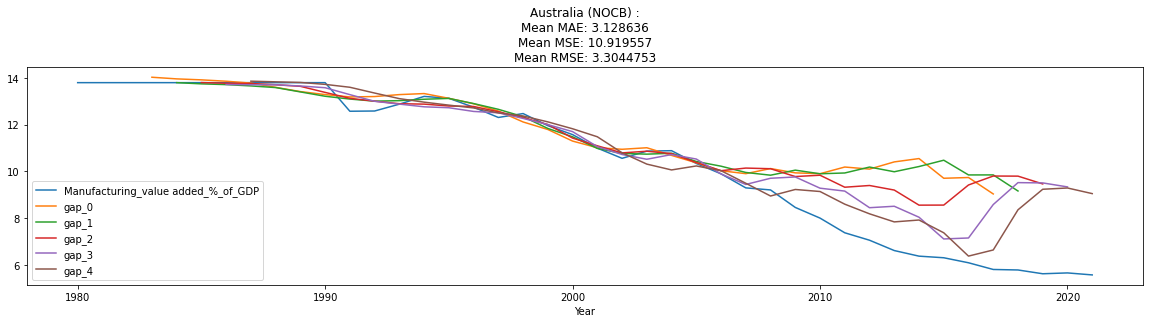

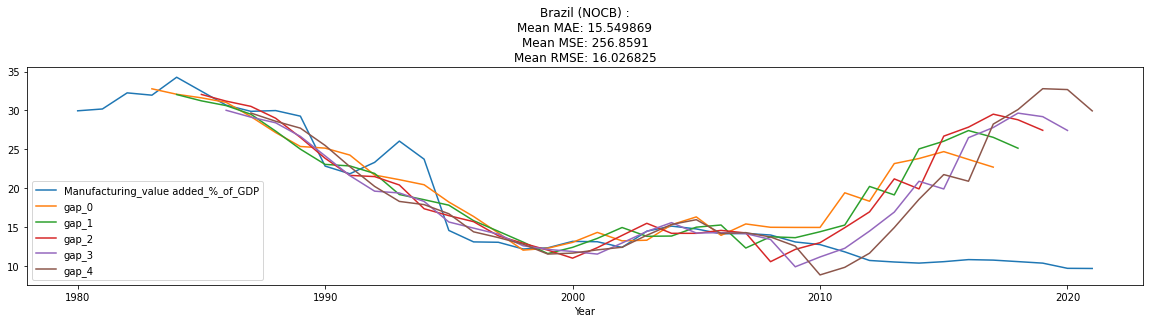

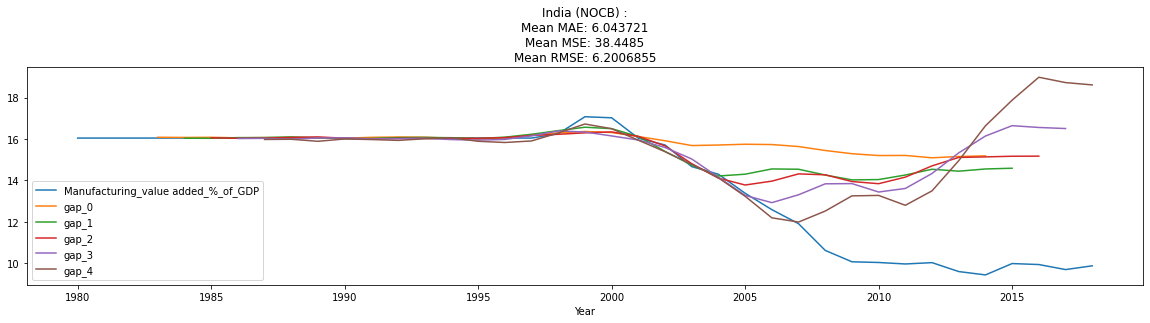

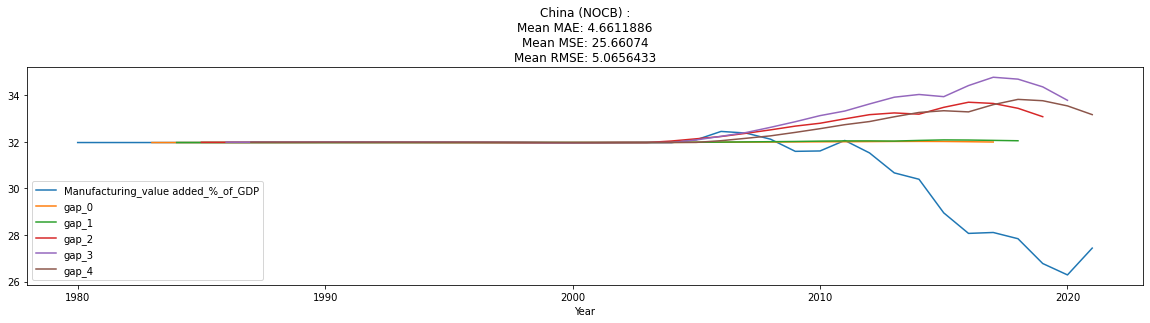

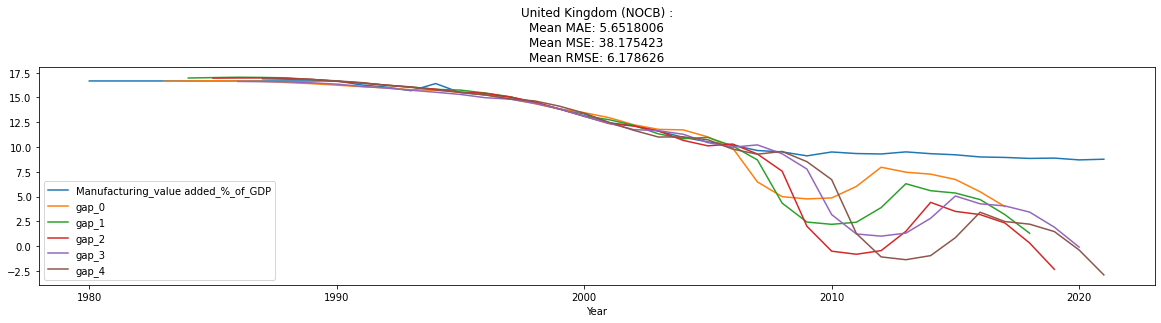

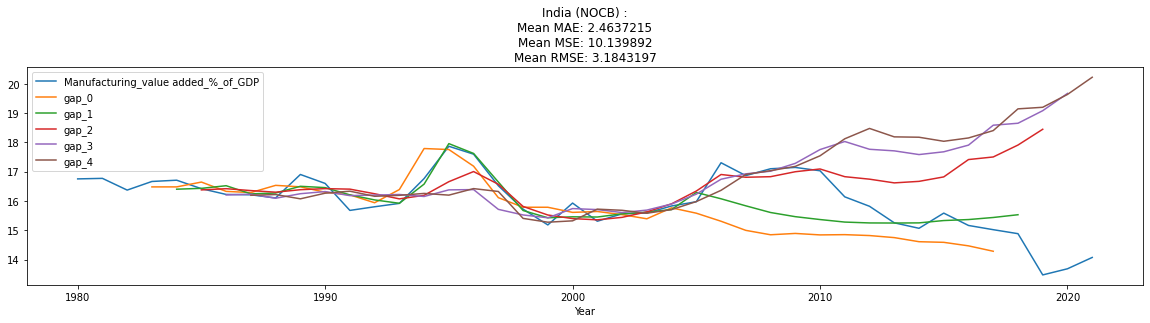

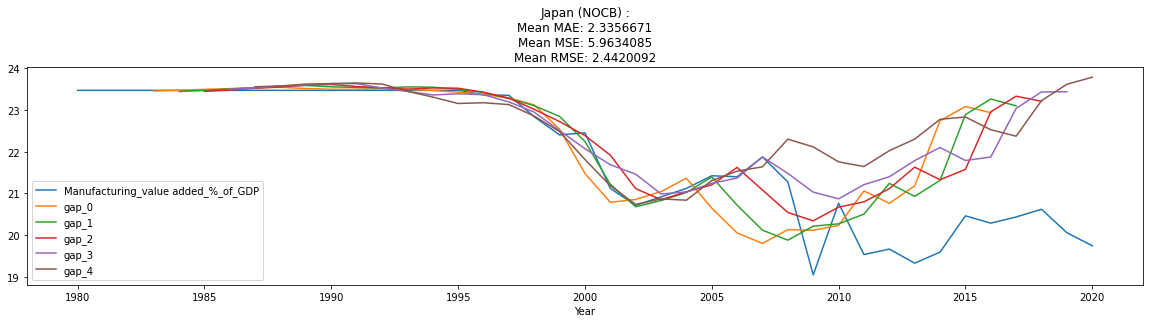

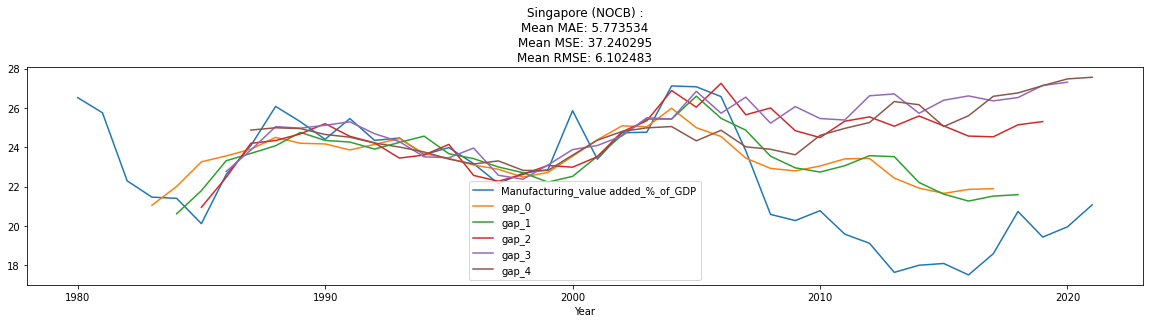

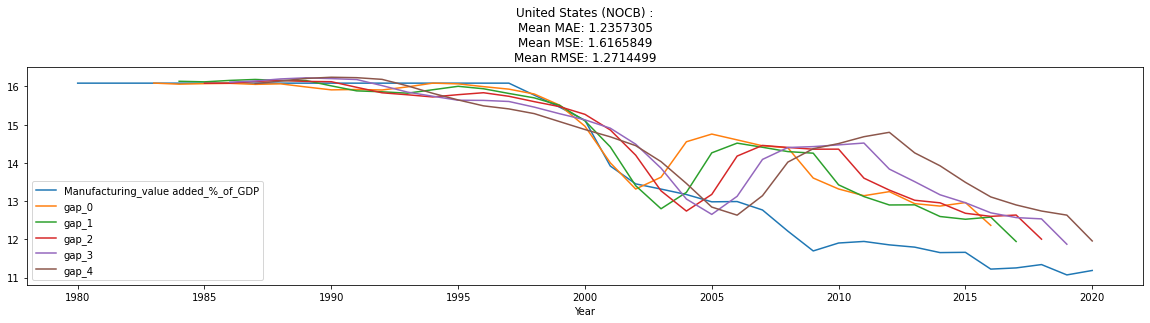

In [ ]:
for sheet in get_sheet_by_methods(Data_dic_s, 3):
  country = sheet[:3]
  method = sheet[3:].strip()
  print(dic_country[country], method, ':')
  try:
    a1, s1, r1 = pipeline(country, method)
    c.append(country)
    m.append(method)
    a.append(a1)
    s.append(s1)
    r.append(r1)
    print('\n')
  except:
    print(f'Cannot handle {country}, {method}')

###### Rolling Stats

Australia Rolling statistics :
Total Modelling Time:  16.17544651031494
1/1 [==============================] - 1s 1s/step
MAE [2.196137, 1.9886959, 1.6152931, 1.3320723, 1.1568543]  Mean MAE 1.6578103 
MSE [5.041041, 4.2194705, 2.9153857, 2.1489491, 1.734622]  Mean MSE 3.211894 
RMSE [2.2452261, 2.054135, 1.70745, 1.4659294, 1.3170505] Mean RMSE 1.7921758
1/1 [==============================] - 0s 80ms/step


1/1 [==============================] - 1s 1s/step


AUS_Rolling statistics
2022               12.077915
2023               12.159005
2024               12.230388
2025               12.430775
2026               12.522198



Brazil Rolling statistics :
Total Modelling Time:  15.778362035751343
1/1 [==============================] - 1s 1s/step
MAE [2.921499, 3.2384307, 3.4640894, 3.8930407, 4.3573728]  Mean MAE 3.5748866 
MSE [9.013326, 11.368694, 13.424088, 17.539003, 22.49823]  Mean MSE 14.768668 
RMSE [3.0022202, 3.3717494, 3.6638896, 4.187959, 4.74323] Mean RMSE 3.8430026
2/2 [==============================] - 0s 15ms/step


1/1 [==============================] - 1s 1s/step


BRA_Rolling statistics
2022               10.257864
2023               10.551215
2024               11.108097
2025               11.408039
2026               12.318470



India Rolling statistics :
Total Modelling Time:  13.958929777145386
1/1 [==============================] - 1s 1s/step
MAE [2.1757398, 2.0530887, 1.9207416, 1.7750351, 1.7115805]  Mean MAE 1.9272372 
MSE [4.7477026, 4.2209854, 3.698752, 3.1662493, 2.9492211]  Mean MSE 3.7565818 
RMSE [2.1789224, 2.0545037, 1.923214, 1.7793958, 1.7173296] Mean RMSE 1.9381903
1/1 [==============================] - 0s 59ms/step


1/1 [==============================] - 2s 2s/step


CAN_Rolling statistics
2022               12.820862
2023               12.920403
2024               13.060600
2025               13.270653
2026               13.286969



China Rolling statistics :
Total Modelling Time:  14.277157068252563
1/1 [==============================] - 1s 1s/step
MAE [1.3798014, 1.7265631, 1.8899683, 2.31699, 2.5553398]  Mean MAE 1.9737325 
MSE [2.0220106, 3.087946, 3.7382135, 5.536671, 6.616467]  Mean MSE 4.2002616 
RMSE [1.4219742, 1.7572552, 1.933446, 2.3530133, 2.5722494] Mean RMSE 2.049454
1/1 [==============================] - 0s 61ms/step


1/1 [==============================] - 1s 1s/step


CHN_Rolling statistics
2022               31.831152
2023               31.879641
2024               31.879894
2025               31.735308
2026               31.698524



United Kingdom Rolling statistics :
Total Modelling Time:  15.808261156082153
1/1 [==============================] - 1s 1s/step
MAE [1.446357, 1.5540568, 1.6417587, 1.5055916, 1.6668354]  Mean MAE 1.56292 
MSE [2.6774106, 3.1578505, 3.5357487, 2.8401484, 3.5280457]  Mean MSE 3.1478405 
RMSE [1.6362795, 1.7770342, 1.8803587, 1.685274, 1.8783092] Mean RMSE 1.7742155
1/1 [==============================] - 0s 74ms/step


1/1 [==============================] - 1s 1s/step


GBR_Rolling statistics
2022               15.154132
2023               15.511478
2024               15.579132
2025               15.623255
2026               15.711959



India Rolling statistics :
Total Modelling Time:  14.425593614578247
1/1 [==============================] - 1s 1s/step
MAE [0.2804955, 0.2659316, 0.24097347, 0.33498463, 0.7945029]  Mean MAE 0.3833776 
MSE [0.110796005, 0.09309181, 0.0824204, 0.2185343, 0.7678988]  Mean MSE 0.25454828 
RMSE [0.33286035, 0.3051095, 0.28708953, 0.46747652, 0.87629837] Mean RMSE 0.5045278
2/2 [==============================] - 0s 13ms/step


1/1 [==============================] - 1s 1s/step


IND_Rolling statistics
2022               15.860731
2023               15.742307
2024               15.707458
2025               15.790536
2026               15.987406



Japan Rolling statistics :
Total Modelling Time:  13.786289930343628
1/1 [==============================] - 2s 2s/step
MAE [1.3318415, 1.176435, 1.0600228, 0.8223052, 0.85959625]  Mean MAE 1.0500401 
MSE [1.7794852, 1.439111, 1.2069659, 0.9549283, 0.93887734]  Mean MSE 1.2638736 
RMSE [1.3339735, 1.1996295, 1.09862, 0.9772043, 0.9689568] Mean RMSE 1.1242213
1/1 [==============================] - 0s 70ms/step


1/1 [==============================] - 1s 1s/step


JPN_Rolling statistics
2022               21.804855
2023               21.989481
2024               22.004343
2025               22.159042
2026               22.203033



Singapore Rolling statistics :
Total Modelling Time:  15.287504434585571
1/1 [==============================] - 1s 1s/step
MAE [3.52312, 4.1770844, 4.776961, 4.9025, 4.6330514]  Mean MAE 4.4025435 
MSE [12.917686, 17.758259, 23.024025, 24.151953, 21.493828]  Mean MSE 19.869148 
RMSE [3.5941184, 4.214055, 4.7983356, 4.9144635, 4.6361437] Mean RMSE 4.4574823
2/2 [==============================] - 0s 14ms/step


1/1 [==============================] - 1s 1s/step


SGP_Rolling statistics
2022               23.836971
2023               24.190281
2024               24.690067
2025               24.856241
2026               24.724018



United States Rolling statistics :
Total Modelling Time:  15.106241941452026
1/1 [==============================] - 1s 1s/step
MAE [0.7009659, 0.70728207, 0.72761106, 0.73785686, 0.7312341]  Mean MAE 0.72099 
MSE [0.50995183, 0.52027094, 0.5494406, 0.5638548, 0.5487473]  Mean MSE 0.5384531 
RMSE [0.7141091, 0.7212981, 0.74124265, 0.75090265, 0.7407748] Mean RMSE 0.7337936
1/1 [==============================] - 0s 78ms/step


1/1 [==============================] - 1s 1s/step


USA_Rolling statistics
2022               12.864563
2023               12.860644
2024               12.895964
2025               12.861070
2026               12.858025

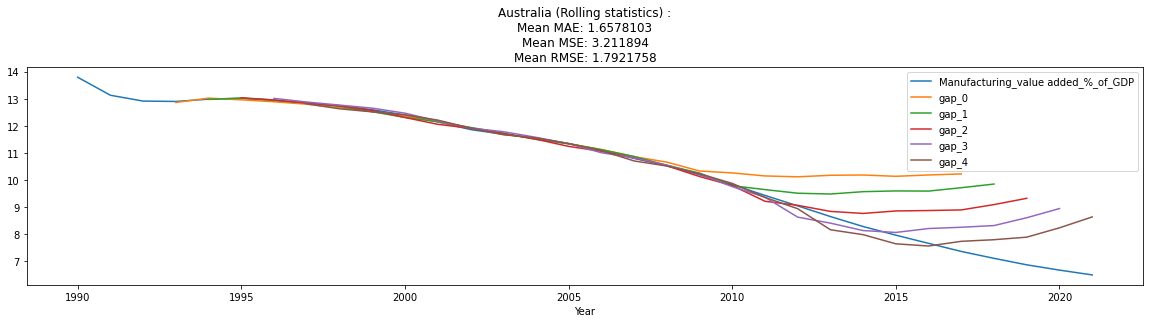

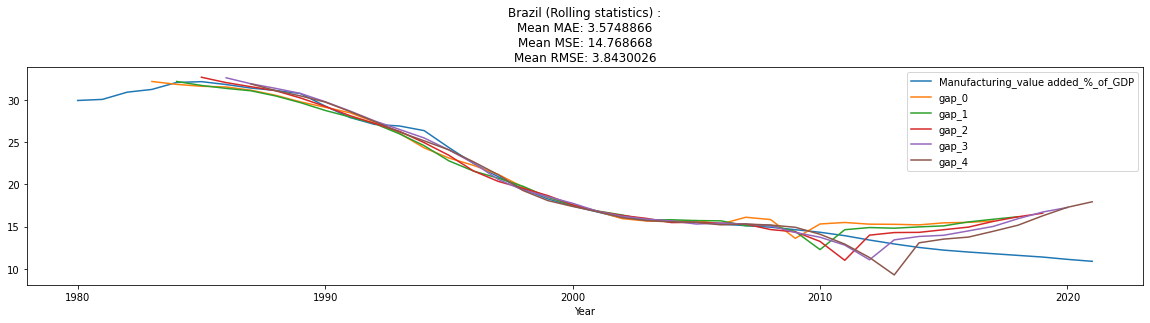

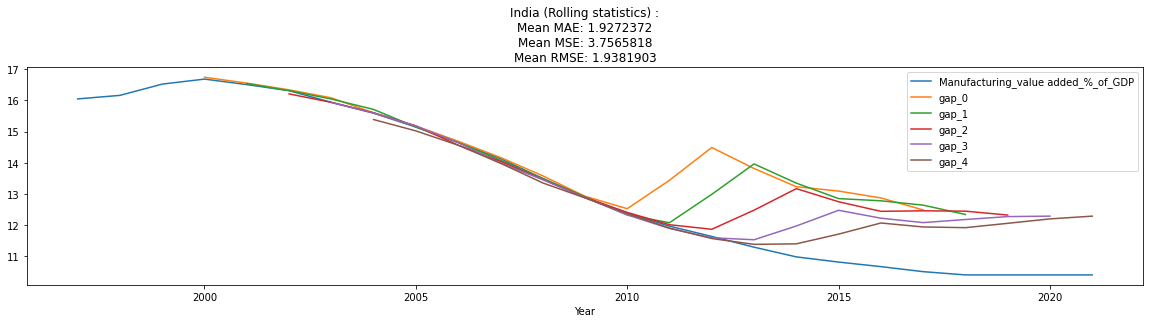

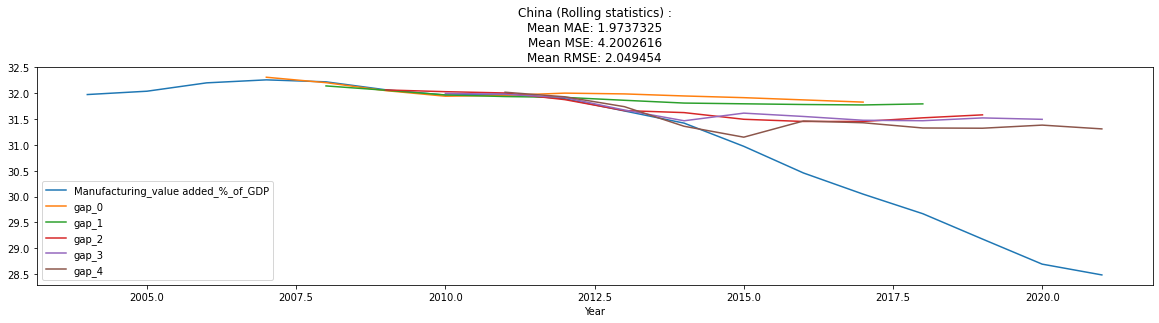

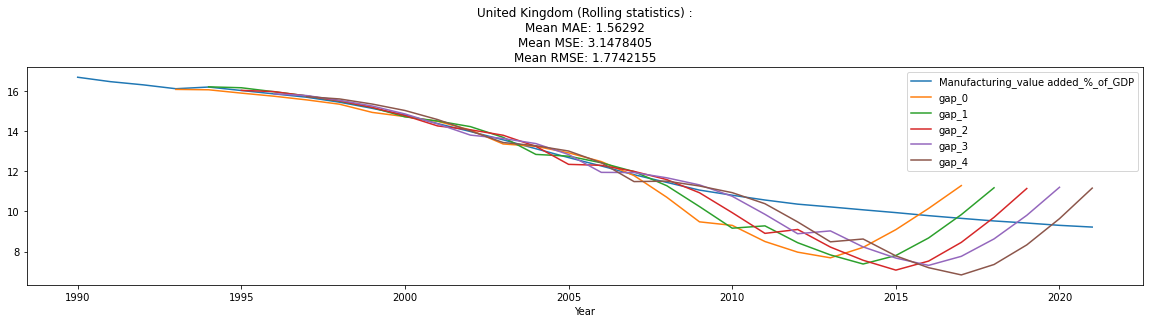

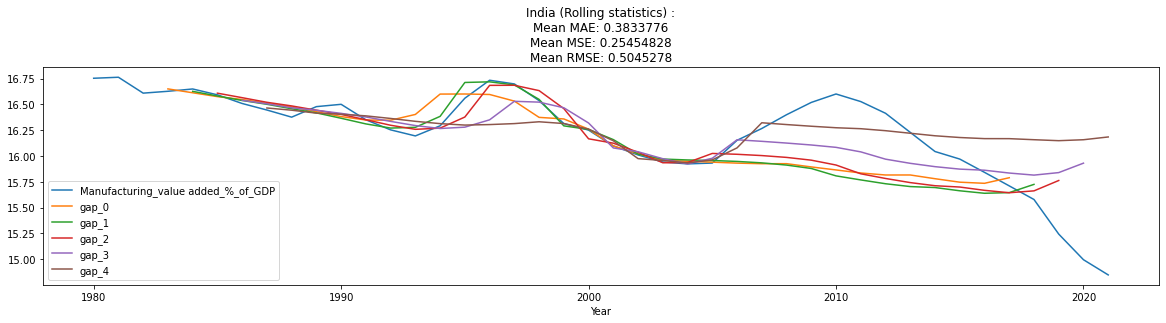

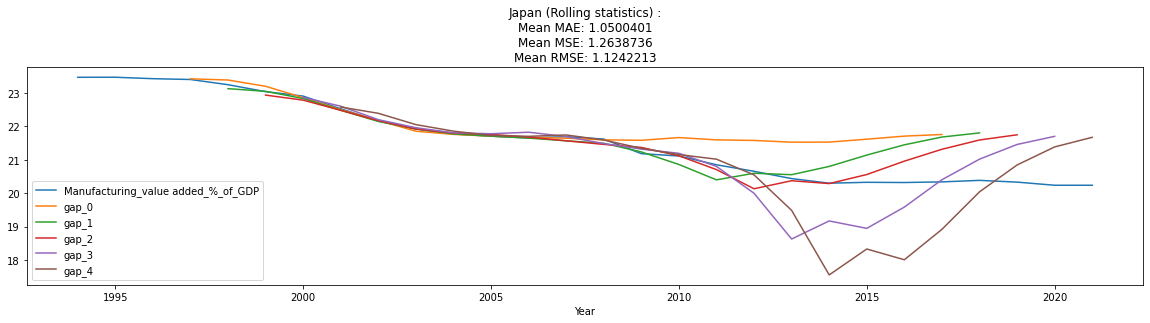

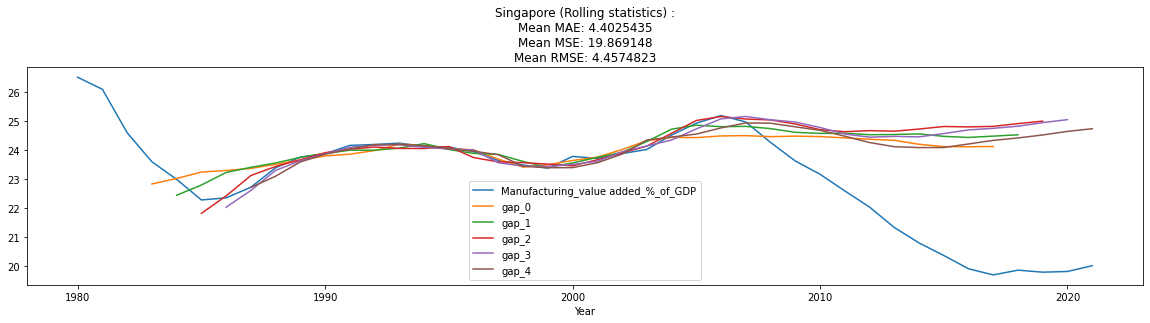

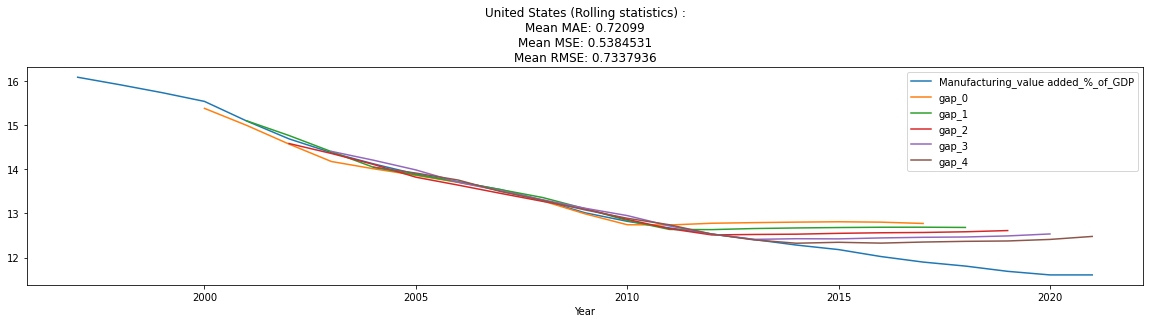

In [ ]:
for sheet in get_sheet_by_methods(Data_dic_s, 4):
  country = sheet[:3]
  method = sheet[3:].strip()
  print(dic_country[country], method, ':')
  try:
    a1, s1, r1 = pipeline(country, method)
    c.append(country)
    m.append(method)
    a.append(a1)
    s.append(s1)
    r.append(r1)
    print('\n')
  except:
    print(f'Cannot handle {country}, {method}')

###### Interpolate

In [ ]:
for sheet in get_sheet_by_methods(Data_dic_s, 5):
  country = sheet[:3]
  method = sheet[3:].strip()
  print(dic_country[country], method, ':')
  try:
    a1, s1, r1 = pipeline(country, method)
    c.append(country)
    m.append(method)
    a.append(a1)
    s.append(s1)
    r.append(r1)
    print('\n')
  except:
    print(f'Cannot handle {country}, {method}')

Australia Interpolate :
Cannot handle AUS, Interpolate
Brazil Interpolate :
Cannot handle BRA, Interpolate
India Interpolate :
Cannot handle CAN, Interpolate
China Interpolate :
Cannot handle CHN, Interpolate
United Kingdom Interpolate :
Cannot handle GBR, Interpolate
India Interpolate :
Cannot handle IND, Interpolate
Japan Interpolate :
Cannot handle JPN, Interpolate
Singapore Interpolate :
Cannot handle SGP, Interpolate
United States Interpolate :
Cannot handle USA, Interpolate


###### Summary

In [ ]:
pd.DataFrame({
    'country': c,
    'method': m,
    'ME': a,
    'MSE': s,
    'RMSE': r
})

country              method         ME         MSE       RMSE
0      AUS                Mean   3.659297   15.685410   3.960481
1      BRA                Mean   6.442457   49.279697   7.019950
2      CAN                Mean   1.421811    3.230976   1.797492
3      CHN                Mean   1.768471    3.815986   1.953455
4      GBR                Mean   3.299951   17.123386   4.138041
5      IND                Mean   1.296788    2.940801   1.714877
6      JPN                Mean   1.500848    2.631255   1.622114
7      SGP                Mean   2.878323    9.822615   3.134105
8      USA                Mean   0.536877    0.427662   0.653959
9      AUS              Median   5.812612   35.613823   5.967732
10     BRA              Median  16.105410  276.663116  16.633194
11     CAN              Median   1.414017    2.559659   1.599893
12     CHN              Median   2.665986    8.442811   2.905652
13     GBR              Median   2.096256    8.086452   2.843669
14     IND              Median   1.156897    2.307048   1.518897
15     JPN              Median   1.311056    2.082284   1.443012
16     SGP              Median   3.771941   16.118763   4.014818
17     USA              Median   0.357335    0.317181   0.563188
18     AUS                LOCF   2.473979    6.715114   2.591354
19     BRA                LOCF  16.955376  300.786774  17.343204
20     CAN                LOCF   0.306237    0.142315   0.377246
21     CHN                LOCF   2.713278    8.775313   2.962316
22     GBR                LOCF   0.574835    0.601050   0.775274
23     IND                LOCF   1.230222    2.506886   1.583315
24     JPN                LOCF   1.002321    1.450778   1.204483
25     SGP                LOCF   3.749553   15.671058   3.958669
26     USA                LOCF   0.539366    0.315722   0.561892
27     AUS                NOCB   3.128636   10.919557   3.304475
28     BRA                NOCB  15.549869  256.859100  16.026825
29     CAN                NOCB   6.043721   38.448502   6.200686
30     CHN                NOCB   4.661189   25.660740   5.065643
31     GBR                NOCB   5.651801   38.175423   6.178626
32     IND                NOCB   2.463722   10.139892   3.184320
33     JPN                NOCB   2.335667    5.963408   2.442009
34     SGP                NOCB   5.773534   37.240295   6.102483
35     USA                NOCB   1.235731    1.616585   1.271450
36     AUS  Rolling statistics   1.657810    3.211894   1.792176
37     BRA  Rolling statistics   3.574887   14.768668   3.843003
38     CAN  Rolling statistics   1.927237    3.756582   1.938190
39     CHN  Rolling statistics   1.973732    4.200262   2.049454
40     GBR  Rolling statistics   1.562920    3.147840   1.774215
41     IND  Rolling statistics   0.383378    0.254548   0.504528
42     JPN  Rolling statistics   1.050040    1.263874   1.124221
43     SGP  Rolling statistics   4.402544   19.869148   4.457482
44     USA  Rolling statistics   0.720990    0.538453   0.733794